In [1]:
import sys
import os
# Check if in colab environment
colabEnv = False
try:
    from google.colab import drive
    colabEnv=True
    drive.mount('/content/drive')
except:
    print('Not in Google Colab environment')


Not in Google Colab environment


In [2]:
# create a softlink to the BTCHelper.py python code for importing
if colabEnv:
    if not os.path.exists('/content/BTCHelper.py'): 
        !ln -s /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/Final/BTCHelper.py /content


In [3]:
import os
import BTCHelper as btc
import importlib # for reloading local class 
# modst are imported in BTCHelper, but may need here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [4]:
dataPath = '../DataSetBrainTumor' # dir or link to dir for running local
outputPath = 'output' # dir or link to dir (where the source file is)
if os.path.exists('/content/drive'): 
    # make a directory at current working directory
    if not os.path.exists('DataSetBrainTumor'):
        !mkdir DataSetBrainTumor  
    # copy *.h5 files to root of current working directory
    !cp /content/drive/MyDrive/ColabData/07-Capstone/DataSetBrainTumor/*_256.h5 DataSetBrainTumor/   
    !cp /content/drive/MyDrive/ColabData/07-Capstone/DataSetBrainTumor/*_224.h5 DataSetBrainTumor/   
    # list contents of the dir
    !ls -al DataSetBrainTumor/
    # drive for data
    dataPath = "./DataSetBrainTumor"
    # Output path for figures and models when using google colab
    outputPath = '/content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output'

def cleanup():
    if colabEnv:
        !rm -rf /content/DataSetBrainTumor/
        !rm -rf /content/__pycache__/
        !rm /content/BTCHelper.py
        !rm -rf /content/__MACOSX/

# Output path for figures, models, and model-tuning
modelPath = os.path.join(outputPath,'models')
figurePath = os.path.join(outputPath,'figures')
modelTunerPath = os.path.join(outputPath,'model-tuner')

# Normalize paths for saving outputs
saveFilePrefix = 'final_10_'
def getFigurePath(fn):
    return os.path.join(figurePath, saveFilePrefix + fn)

def getModelPath(fn):
    return os.path.join(modelPath, saveFilePrefix + fn)

def getModelTunerPath(fn):
    return os.path.join(modelTunerPath, saveFilePrefix + fn)

# since we are doing this may times for different reasons
def loadImagesDataset(imageShape=(256,256,1),trainOrTest='training'):
    importlib.reload(btc) # during refactorings
    if trainOrTest == 'training':
        h5File = os.path.join(dataPath,'Training_'+str(imageShape[0])+'.h5')
    elif trainOrTest == 'testing':
        h5File = os.path.join(dataPath,'Testing_'+str(imageShape[0])+'.h5')
    assert os.path.exists(h5File)
    imgArr,imgLabels,imgSummDf = btc.DataUtils.readHdf5File(h5File)
    return imgArr,imgLabels,imgSummDf


### **Load image data for Exploratory Data Analysis (EDA)**

In [5]:
importlib.reload(btc) # during refactoring
# Read image data
trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(trainOrTest='training')
testImgs,testLabels,testImgSummDf = loadImagesDataset(trainOrTest='testing')
# # print shapes
print()
print('-'*80)
print(f'Training: images shape {trainImgs.shape}, labels shape {trainLabels.shape}')
print(f'Testing: images shape {testImgs.shape}, labels shape {testImgs.shape}')
print('-'*80)
labelDistDf = btc.getLabelDistributionDf(dict(train=trainLabels,test=testLabels))
display(labelDistDf)



Reading HDF5 file ../DataSetBrainTumor/Training_256.h5
Reading HDF5 file ../DataSetBrainTumor/Testing_256.h5

--------------------------------------------------------------------------------
Training: images shape (2881, 256, 256), labels shape (2881,)
Testing: images shape (402, 256, 256), labels shape (402, 256, 256)
--------------------------------------------------------------------------------


train  trainFraction   test  testFraction
glioma       829.0       0.287747  100.0      0.248756
meningioma   830.0       0.288094  115.0      0.286070
no_tumor     395.0       0.137105  113.0      0.281095
pituitary    827.0       0.287053   74.0      0.184080
Total       2881.0       1.000000  402.0      1.000000


Training Images


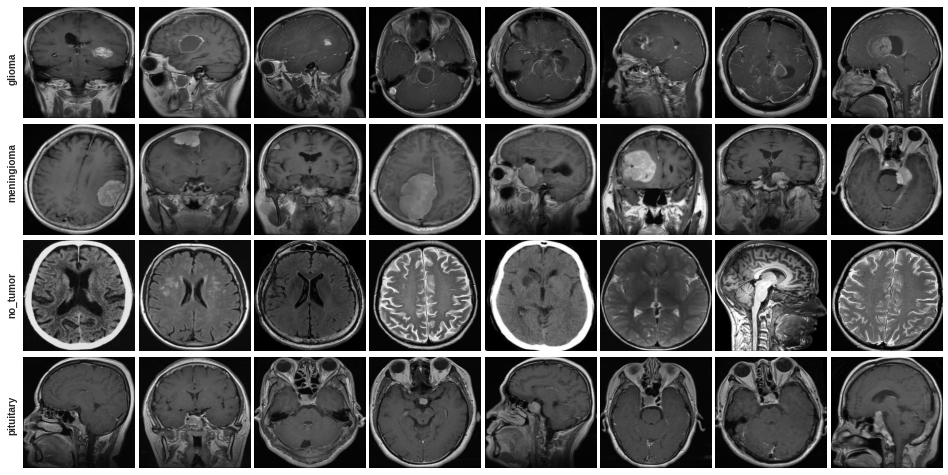


Testing Images


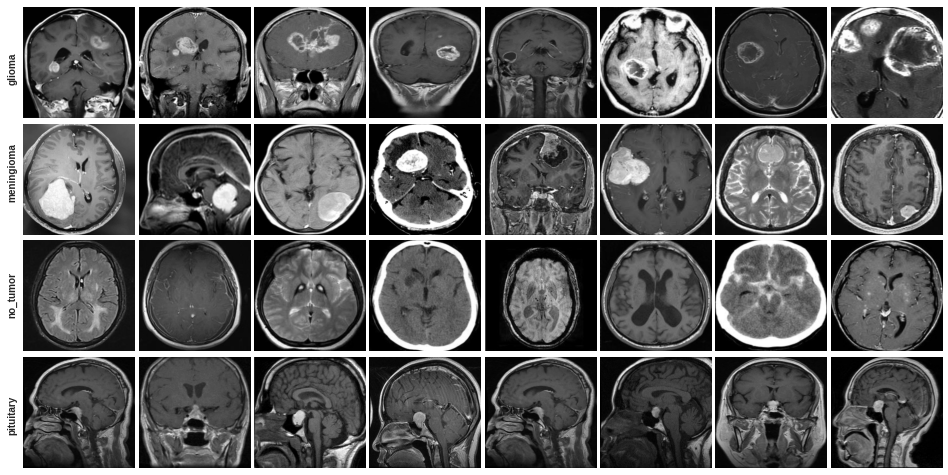

In [ ]:
importlib.reload(btc) # during refactoring
# get 8 random samples for each category
trIdx = trainImgSummDf.groupby('tumorCategory').sample(n=8).index
figFile = getFigurePath('trainingImageArray.png')
print('\nTraining Images')
btc.plotImageArr(nRows=4,nCols=8,figSize=(16,8),imgArr=trainImgs[trIdx],
                 rowLabels=trainLabels[trIdx],figFile=figFile)
# testing images
print('\nTesting Images')
tsIdx = testImgSummDf.groupby('tumorCategory').sample(n=8).index
figFile = getFigurePath('testingImageArray.png')
btc.plotImageArr(nRows=4,nCols=8,figSize=(16,8),imgArr=testImgs[tsIdx],
                 rowLabels=testLabels[tsIdx],figFile=figFile)




Distribution of tumor categories in the dataset


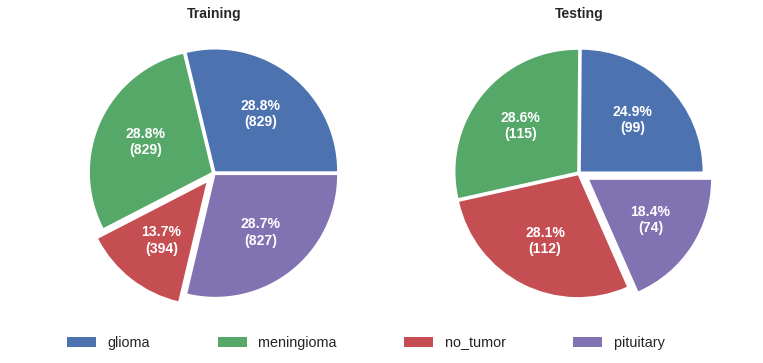

In [ ]:
importlib.reload(btc) # during refactorings
print()
print('\nDistribution of tumor categories in the dataset')
figFile = getFigurePath('categoryDistribution.png')
btc.plotPieDistribution(trainImgSummDf,testImgSummDf,figFile)



Distribution of original width and height of images in the dataset


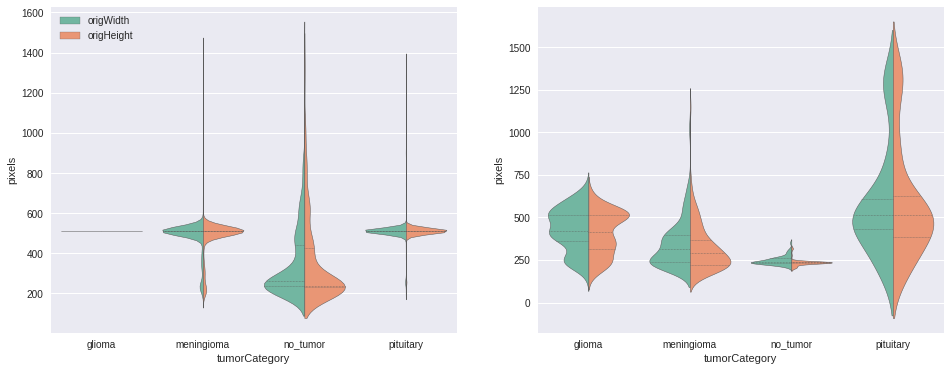

In [ ]:
importlib.reload(btc) # during refactorings
print()
print('\nDistribution of original width and height of images in the dataset')
figFile = getFigurePath('imageSizeOriginalViolin.png')    
btc.plotWidthHeightViolin(trainImgSummDf,testImgSummDf,
                          ['origWidth','origHeight'],figFile=figFile)




Distribution of cropped width and height of images in the dataset


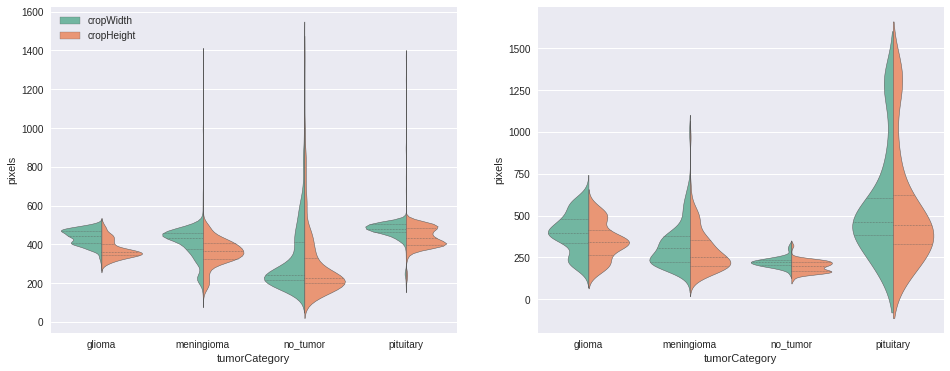

In [ ]:
print()
print('\nDistribution of cropped width and height of images in the dataset')
figFile = getFigurePath('imageSizeCoroppedViolin.png')    
btc.plotWidthHeightViolin(trainImgSummDf,testImgSummDf,
                          ['cropWidth','cropHeight'],figFile=figFile)




Distribution of original aspect ratio of images in the dataset


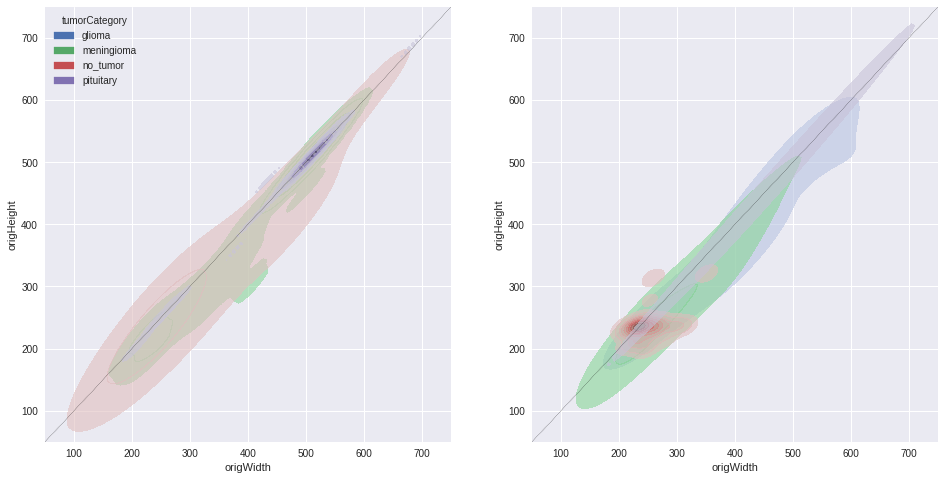

In [ ]:
importlib.reload(btc) # during refactorings
print()
print('\nDistribution of original aspect ratio of images in the dataset')        
figFile = getFigurePath('imageAspectOriginal.png') 
btc.plotAspect(trainImgSummDf,testImgSummDf,['origWidth','origHeight'],
           lims=[50,750],figFile=figFile)




Distribution of cropped aspect ratio of images in the dataset


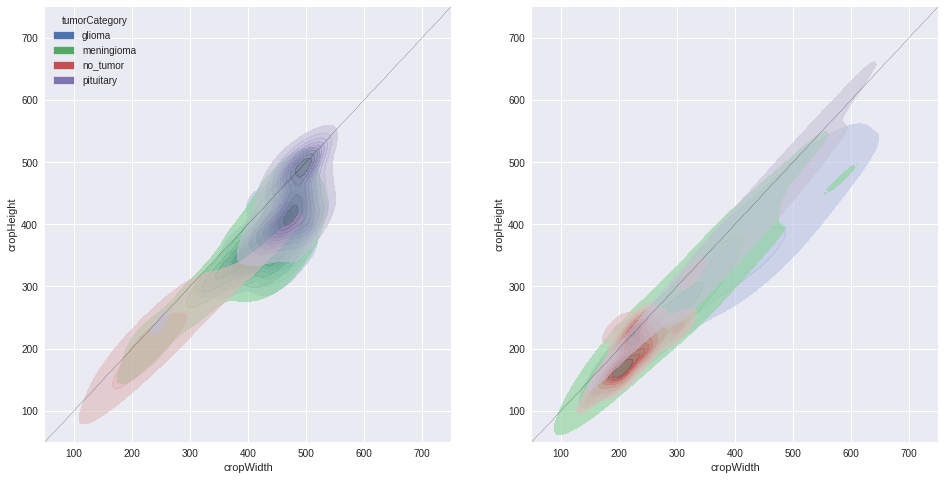

In [ ]:
print()
print('\nDistribution of cropped aspect ratio of images in the dataset')        
figFile = getFigurePath('imageAspectCropped.png') 
btc.plotAspect(trainImgSummDf,testImgSummDf,['cropWidth','cropHeight'],
           lims=[50,750],figFile=figFile)



Distribution of raw pixel values of images in the dataset


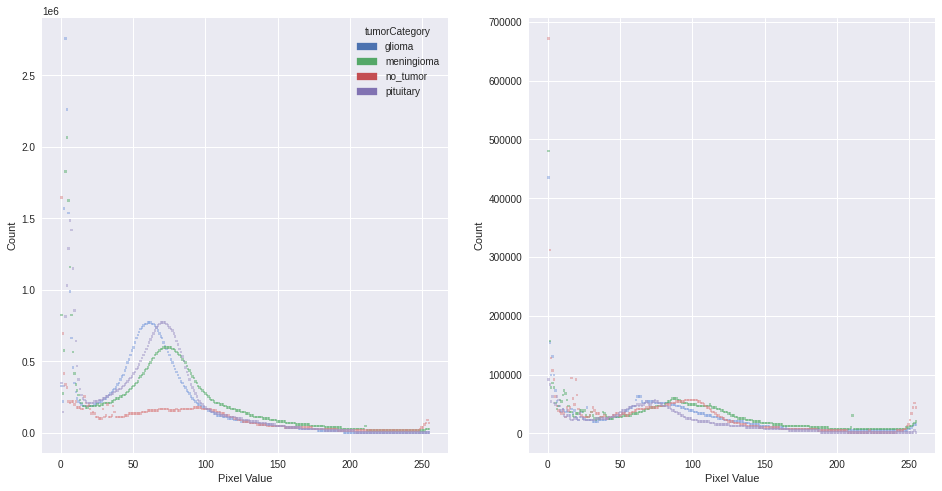

In [ ]:
importlib.reload(btc) # during refactorings
print()
print('\nDistribution of raw pixel values of images in the dataset')        
figFile = getFigurePath('imagePixelValueDistribution.png') 
btc.plotPixelValueDist(trainImgs,testImgs,trainImgSummDf,testImgSummDf,
                       scale='Count',ylim=[],figFile=figFile)



Distribution of raw pixel values of images in the dataset


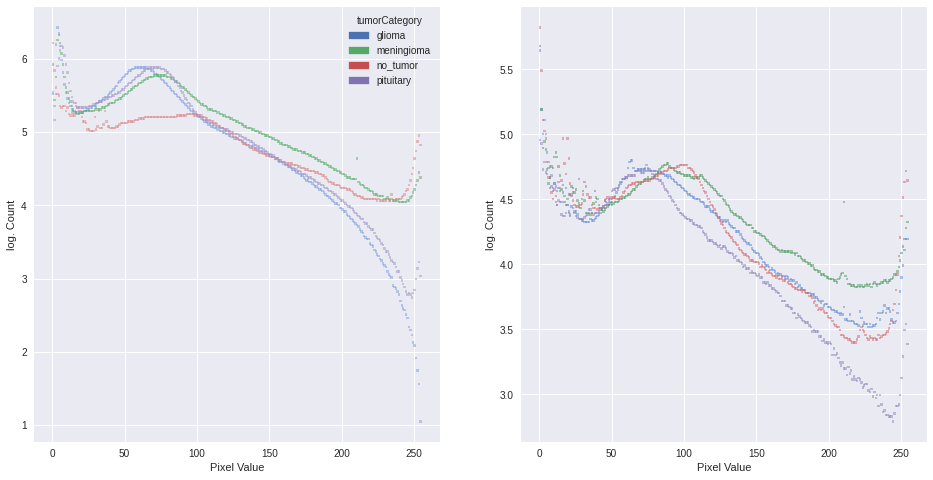

In [ ]:
print()
print('\nDistribution of raw pixel values of images in the dataset')        
figFile = getFigurePath('imagePixelValueDistributionLog.png') 
btc.plotPixelValueDist(trainImgs,testImgs,trainImgSummDf,testImgSummDf,
                       scale='log',ylim=[],figFile=figFile)



Application of different image processing techniques to the dataset


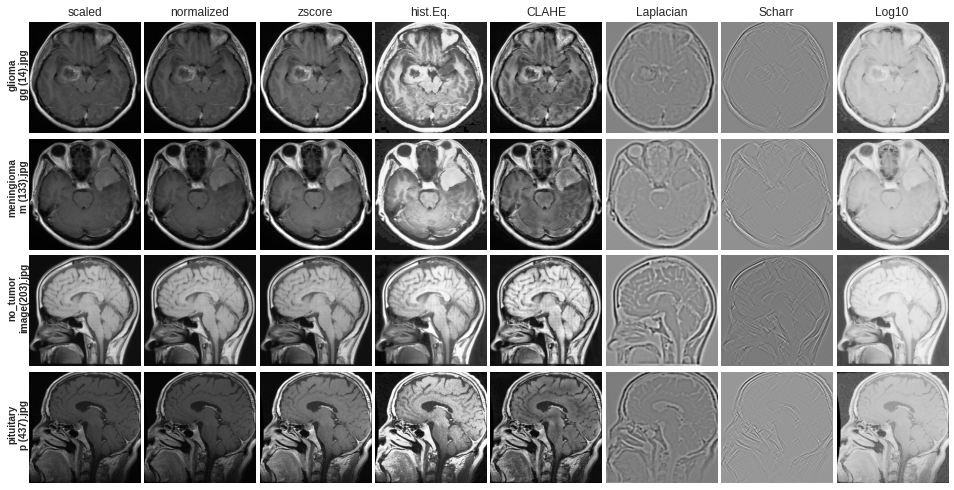

In [ ]:
importlib.reload(btc) # during refactorings
trIdx = trainImgSummDf.groupby('tumorCategory').sample(n=1).index
catNames = trainImgSummDf['tumorCategory'][trIdx].values
fileIds = trainImgSummDf['fileId'][trIdx].values
txImgArr = []
rowLabels = []
colLabels =['scaled','normalized','zscore','hist.Eq.',
            'CLAHE','Laplacian','Scharr','Log10']
def colFunctions(xx):
    return [xx/255.0,btc.imNorm(xx),btc.imZsc(xx),btc.imHe(xx),
            btc.imClahe(xx),btc.imLaplacian(xx),btc.imScharr(xx),btc.imLog(xx)]

for ix in range(len(trIdx)):   
    fileId = fileIds[ix]
    catName = catNames[ix]
    lab = catName + '\n' + fileId
    rowLabels.extend([lab]*len(colLabels)) # same image transformed n times
    txImgArr.extend(colFunctions(trainImgs[trIdx[ix],:,:]))
    
txImgArr=np.array(txImgArr)
print()
print('\nApplication of different image processing techniques to the dataset')        
figFile = getFigurePath('trainingImageArrayFiltered.png') 
btc.plotImageArr(nRows=4,nCols=8,figSize=(16,8),imgArr=txImgArr,
                 rowLabels=rowLabels,colLabels=colLabels,figFile=figFile)


In [ ]:
print('Min and max values after image processing\n')
Z = np.array(colFunctions(trainImgs[5,:,:]))
for i in range(8):
     img=Z[i,:,:]
     print(f'{colLabels[i]} min = {np.min(img)}, max = {np.max(img)}')


Min and max values after image processing

scaled min = 0.0, max = 0.9686274509803922
normalized min = 0.0, max = 1.0
zscore min = -1.3889726222016021, max = 3.0
hist.Eq. min = 0.0, max = 1.0
CLAHE min = 0.0, max = 1.0
Laplacian min = 0.0, max = 1.0
Scharr min = 0.0, max = 1.0
Log10 min = 0.0, max = 1.0


## **Experiments with hyperparameter tuning and Image-Processing combinations**
- Images for the dataset wre pre-process with the following techniques
  * **Raw**: Image grayscale values are used as is. Values are between 0 and 255.
  * **Scaled**: `new_img = image/255.0`. Values are between 0 and 1.
  * **Normalized**: `new_image = (image-min(image))/range(image)` - values are between 0 and 1. 
  * **Z-Score**: `new_image = (image-mean(image))/std(image)` - values are saturated at [-3.0 to +3.0]. Values above 3.0 are set t3 3.0 and below -3 are set to -3.0.
  * **Histogram Equalized**: `new_image = cv2.equalizeHist(im)` and values are used as is. Values are normalize to be between 0 and 1.
  * **CLAHE**: new_imge = `cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4)).apply(im)`. This contrast limited adaptive histogram equalization for improving local-contrast at the same time reducing enhancing of noise. Values are normalized to be between 0 and 1.
 * **Laplacian**: `new_imge = cv2.Laplacian(im, cv2.CV_64F, ksize=21)`. This filter shows edges int he image whle blurring everything else. Values are normalized ot be between 0 and 1.
 

In [ ]:
import keras
from keras.models import Model
from timeit import default_timer as timer
importlib.reload(btc) # during refactorings
# fit model

# Get model to use
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()

# Train model and use early stopping
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta= 0.0005, 
                                              patience=8,
                                              restore_best_weights=True)
#modelCheckpoint = ModelCheckpoint('myModel.h5', verbose=1, save_best_only=True)

def getAllModels(strategy,imageShape,preProcName):
  # 6 models for combination of hyper parameters
    models = []
    modelNames = []
    shape = imageShape
    kernelL2 = 0.00020

    models.append(btc.MyModel.getBaseModel(shape,strategy))
    # Base model
    modelNames.append('BaseModel-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4))
    # Base model - batch norm
    modelNames.append('BaseModel-BatchNorm-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True))
    # Base model - dropout regularize
    modelNames.append('BaseModel-Dropout-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4,drop=0.3))
   # Base model + l2 regularization for kernal
    modelNames.append('BaseModel-L2Regularize-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4,l2Lambda=kernelL2))
    # Base model - batch norm - L2 regularize
    modelNames.append('BaseModel-BatchNorm-L2Regularize-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2))
    # Base model - batch norm - L2 regularize - dropout
    modelNames.append('BaseModel-BatchNorm-L2Regularize-Dropout-'+preProcName)
    models.append(btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2,drop=0.3))
    return dict(zip(modelNames,models))

run_models = False
#print(btc.getPreProcNames()) # for a list of pre-proc-names
imgProcNames = ['ZScore', 'HistEqual', 'CLAHE', 'Laplacian','Scaled', 'Normalize', 'Raw',  'LogTransform']
_st = timer()
modelNo = 0
if run_models: ## Just so we do not overwrite
    # image data size
    imageShape = (256,256,1)
    # create all models...\# 6 * no.-of-preProcs
    namedModels = {}
    [namedModels.update(getAllModels(strategy,imageShape,x)) for x in imgProcNames]
    namedHistories = {}
    print(f'Created all models for different pre-processing runs. N models = {len(namedModels)} ')
    # Read image data
    trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
    testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
    # split and get indices since we need to pre-process images as needed
    tr_ix,vl_ix,_,classWeightsDict = btc.getTrainTestIndexes(trainLabels,testSplit=0.2)
    stPreProc = timer()
    for name,model in namedModels.items():
        modelNo = modelNo + 1
        st = timer()
        # the last part of the model name has the preProcName
        preProcName = name.split('-')[-1]
        print(f'\nImage pre-processing for function: {preProcName} and running all models')
        tr_x,tr_y,vl_x,vl_y,ts_x,ts_y,classLabels = btc.getTrainValTestData(
            trainImgs,trainLabels,tr_ix,vl_ix,testImgs,testLabels,preProcName=preProcName)
        # Fit model
        print(f'\n{modelNo} of {len(namedModels)}. fittig model {name} - PreProcName: {preProcName} ')        
        #class_weight=classWeightsDict not used
        namedHistories[name] = model.fit(tr_x,tr_y,batch_size=16,epochs=250,verbose=0,
                                        validation_data=(vl_x,vl_y),
                                        callbacks = earlyStopping)
        print(f'Time taken to fit : {timer()-st:.3f}s')
        namedModels[name] = model
        # save model
        model.save(getModelPath(name+'.h5'))
        hist_df = pd.DataFrame(namedHistories[name].history)
        with open(getModelPath(name+'_history.csv'), mode='w') as fh:
            hist_df.to_csv(fh)
        print(f'Saved model and history to {getModelPath(name)}')
        print(f'fitted model {name} (No ClassWeights)')
        print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
        btc.plotAccuracyAndLoss(namedHistories[name],getFigurePath(name+'_lossAccuracy.png'))
        clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
        display(clfRepDf)
        clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
        print(f'\nDone running model-{modelNo}: {name} time: {timer()-st}s')
        print('\n\n')
        print('='*100)
        #done for one model-name
#Done if run_models condition
print(f'\nDone running all models for all pre-proc functions time: {timer()-_st}s')




Done running all models for all pre-proc functions time: 0.0005240629998297663s


In [ ]:
import re
# Load validation histories from files
savedFiles = os.listdir(modelPath)
historyFiles = [x for x in savedFiles if re.search('final_06_BaseModel-.*history',x) ]
classificationFiles = [x for x in savedFiles if re.search('final_06_BaseModel-.*classifReport',x) ]
# Get all histories as DF
historyDf = None
for f in historyFiles:
    if (f.find('LogTransform')>-1):
        continue
    temp = pd.read_csv(os.path.join(modelPath,f))
    temp = temp.iloc[:,0:9]
    temp.columns =['epoch','loss','accuracy','precision','recall','val_loss','val_accuracy','val_precision','val_recall']
    if historyDf is None:
        historyDf = temp.copy()
        historyDf['fileId'] = f
    else:
        temp['fileId'] = f
        historyDf = historyDf.append(temp) 
historyDf['modelName'] = ['-'.join(x.split('_')[2].split('-')[:-1]) for x in historyDf['fileId']]
historyDf['imgPreProc'] = [x.split('_')[2].split('-')[-1] for x in historyDf['fileId']]

# Get all classification reports as DF
classifRepDf = pd.read_csv(os.path.join(modelPath,classificationFiles[0]))
classifRepDf['fileId'] = classificationFiles[0]
for f in classificationFiles[1:]:
    if (f.find('LogTransform')>-1):
        continue
    temp = pd.read_csv(os.path.join(modelPath,f))
    temp['fileId'] = f
    classifRepDf = classifRepDf.append(temp)
classifRepDf = classifRepDf.iloc[:,1:]
classifRepDf.columns=['statistic','glioma','meningioma','no_tumor','pituitary','accuracy','macro avg','weighted avg','fileId']
classifRepDf['modelName'] = ['-'.join(x.split('_')[2].split('-')[:-1]) for x in classifRepDf['fileId']]
classifRepDf['imgPreProc'] = [x.split('_')[2].split('-')[-1] for x in classifRepDf['fileId']]
classifRepDf.reset_index(drop=True,inplace=True)


In [ ]:
display(historyDf.head(5))
historyDf['imgPreProc'].unique()

epoch      loss  ...  modelName  imgPreProc
0      0  1.015708  ...  BaseModel      ZScore
1      1  0.606517  ...  BaseModel      ZScore
2      2  0.379654  ...  BaseModel      ZScore
3      3  0.263037  ...  BaseModel      ZScore
4      4  0.143409  ...  BaseModel      ZScore

[5 rows x 12 columns]

array(['ZScore', 'HistEqual', 'CLAHE', 'Laplacian', 'Scaled', 'Normalize',
       'Raw'], dtype=object)


Evaluation metrics for image processing function ZScore




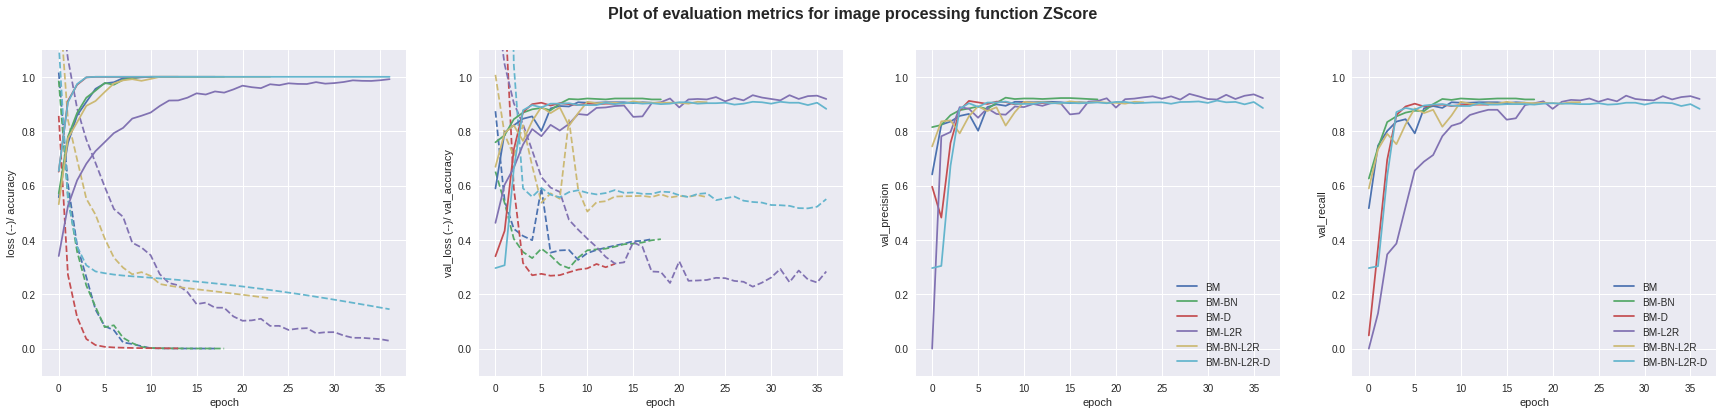


Evaluation metrics for image processing function HistEqual




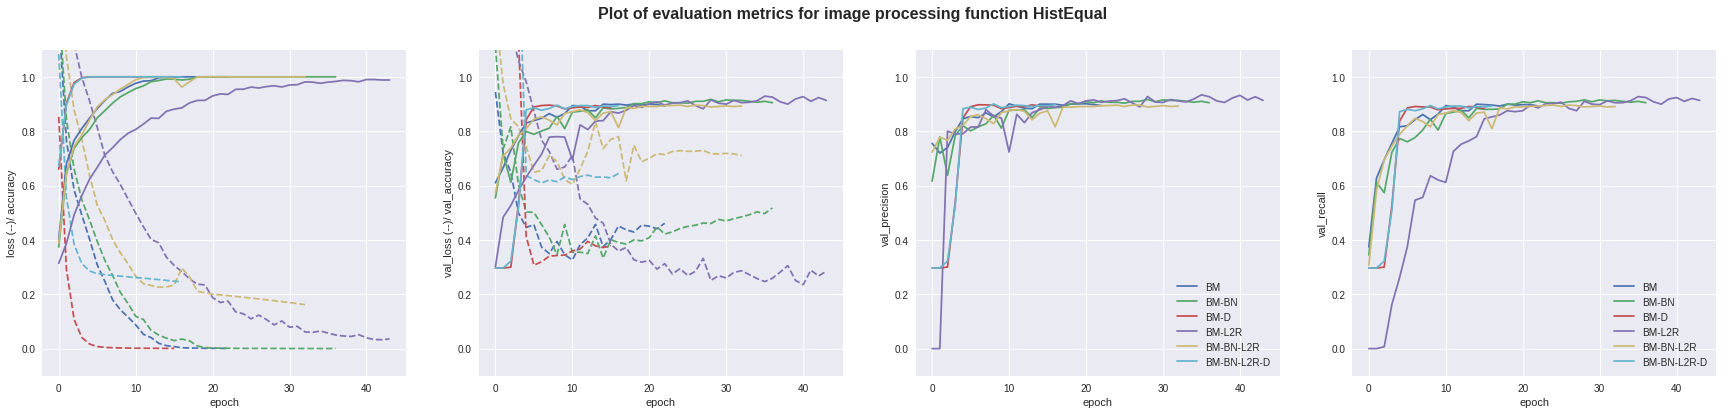


Evaluation metrics for image processing function CLAHE




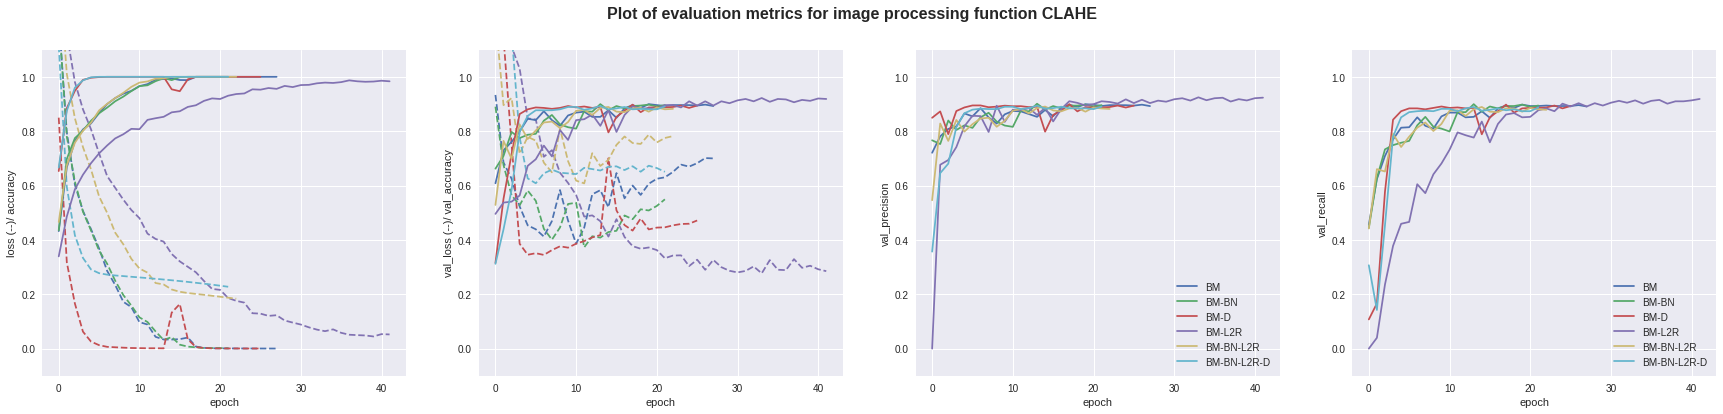


Evaluation metrics for image processing function Laplacian




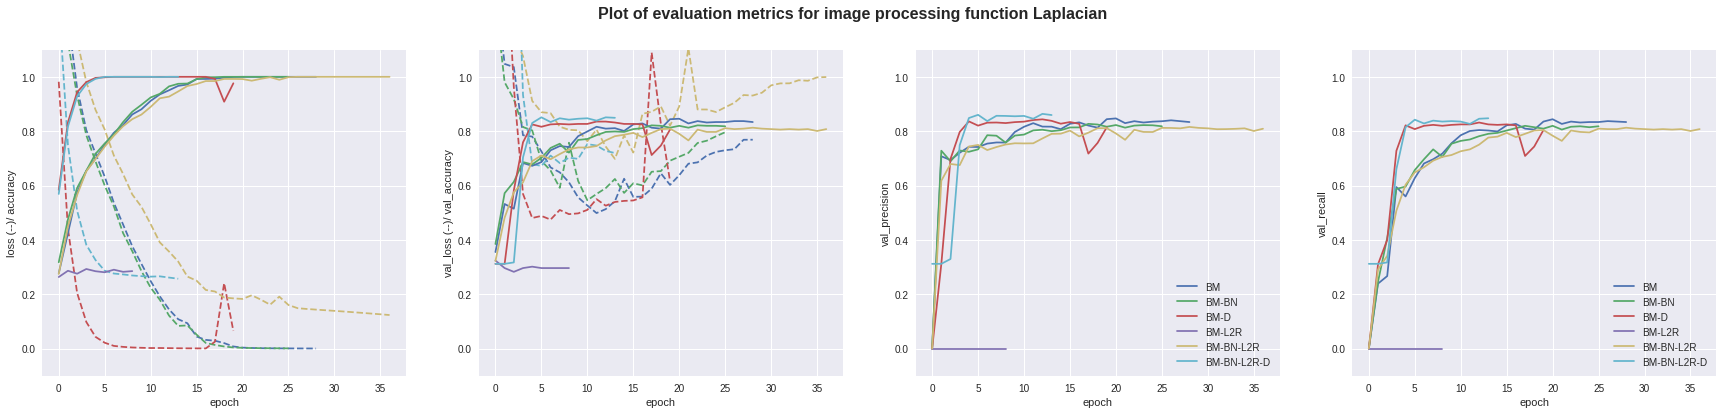


Evaluation metrics for image processing function Scaled




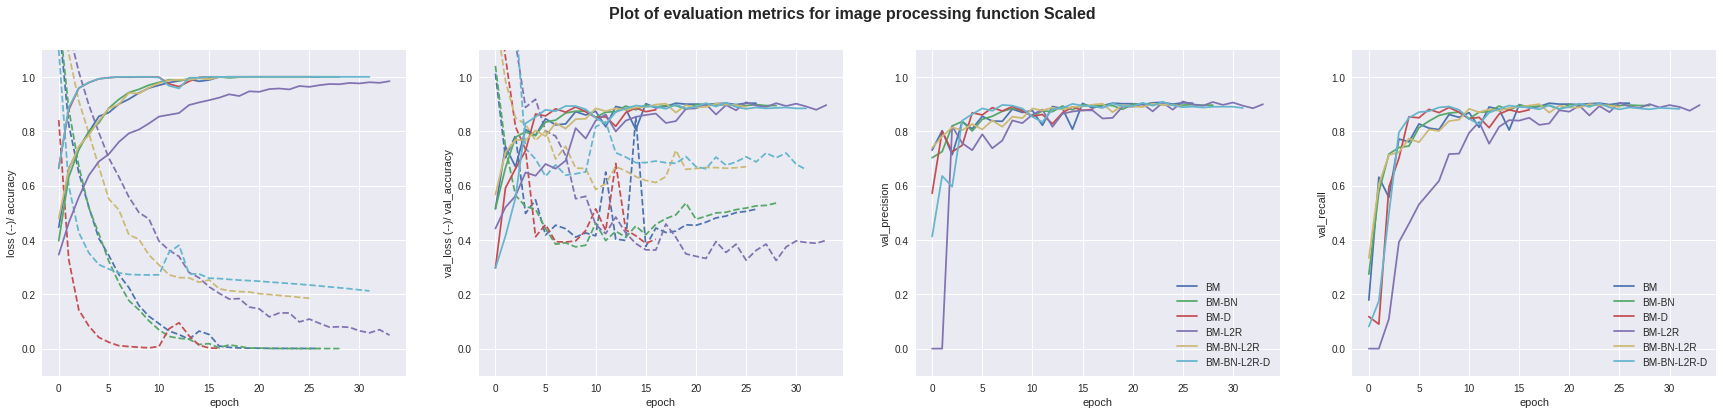


Evaluation metrics for image processing function Normalize




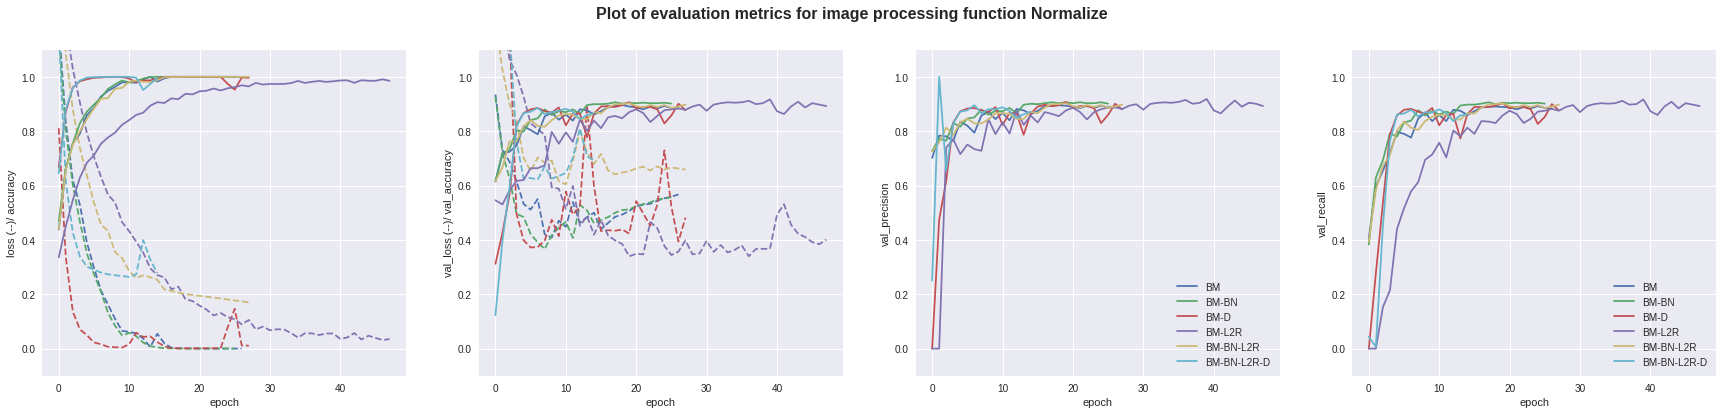


Evaluation metrics for image processing function Raw




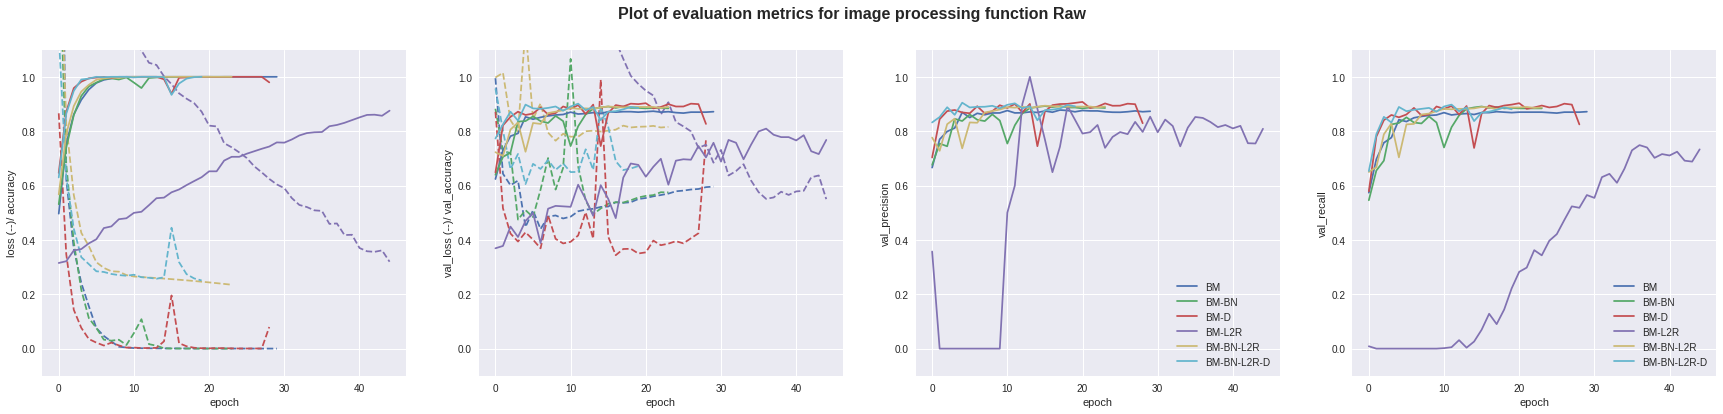

In [ ]:
#For each image processing function
evalMetrics = ['accuracy','val_accuracy','val_precision','val_recall']
for imgPreProc in historyDf['imgPreProc'].unique():
    print(f'\nEvaluation metrics for image processing function {imgPreProc}\n\n')
    data = historyDf[historyDf['imgPreProc']==imgPreProc].copy()
    #df.replace({'A': r'^ba.$'}, {'A': 'new'}, regex=True)
    data.replace({'modelName':r'[a-z]'},{'modelName':''},regex=True,inplace=True)
    fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(30,6))
    pltNo = -1
    for evalMetric in evalMetrics:
        pltNo = pltNo +1
        ax = axs[pltNo]
        if evalMetric == 'accuracy':
            plt.gca().set_prop_cycle(None)
            sns.lineplot(x='epoch',y='loss',hue='modelName',data=data,ax=ax)
            [l.set_linestyle("--") for l in ax.lines]
        if evalMetric == 'val_accuracy':
            plt.gca().set_prop_cycle(None)
            sns.lineplot(x='epoch',y='val_loss',hue='modelName',data=data,ax=ax)
            [l.set_linestyle("--") for l in ax.lines]
            ax.legend(handles=[],labels=[])
    
        g = sns.lineplot(x='epoch',y=evalMetric,hue='modelName',data=data,ax=ax)
        ax.set_ylim([-0.1,1.1])
        if evalMetric == 'accuracy':
            ax.set_ylabel('loss (--)/ accuracy')
        if evalMetric == 'val_accuracy':
            ax.set_ylabel('val_loss (--)/ val_accuracy')
        ax.legend(frameon=False)
        if pltNo < 2:
            g.legend_.remove()
        if pltNo == 0:
            title = f'Plot of evaluation metrics for image processing function {imgPreProc}'
            fig.suptitle(title, fontsize=16, fontweight='bold')
    fn = 'EvaluationMetricsForModel_'+imgPreProc+'.png'
    plt.savefig(getFigurePath(fn),bbox_inches='tight',orientation='landscape')        
    plt.show()

In [ ]:
idxRecall = classifRepDf['statistic']=='recall'
classifRepRecall = classifRepDf.loc[idxRecall,['modelName','imgPreProc','glioma','meningioma','no_tumor','pituitary','accuracy']]
classifRepRecall.sort_values(['glioma','accuracy'],ascending=[False,False],inplace=True)
print('\nTop 10 model and image pre-processing combination')
display(classifRepRecall.head(10))




Top 10 model and image pre-processing combination


modelName imgPreProc  ...  pituitary  accuracy
89   BaseModel-BatchNorm-L2Regularize  Laplacian  ...   0.783784  0.761194
161  BaseModel-BatchNorm-L2Regularize        Raw  ...   0.797297  0.761194
5                 BaseModel-BatchNorm     ZScore  ...   0.675676  0.743781
145                         BaseModel        Raw  ...   0.770270  0.738806
149               BaseModel-BatchNorm        Raw  ...   0.743243  0.743781
125               BaseModel-BatchNorm  Normalize  ...   0.635135  0.716418
29                BaseModel-BatchNorm  HistEqual  ...   0.864865  0.768657
17   BaseModel-BatchNorm-L2Regularize     ZScore  ...   0.797297  0.758706
1                           BaseModel     ZScore  ...   0.662162  0.736318
121                         BaseModel  Normalize  ...   0.662162  0.713930

[10 rows x 7 columns]

In [ ]:
classifRepDf.head(10)


statistic      glioma  ...            modelName  imgPreProc
0  precision    0.941176  ...            BaseModel      ZScore
1     recall    0.320000  ...            BaseModel      ZScore
2   f1-score    0.477612  ...            BaseModel      ZScore
3    support  100.000000  ...            BaseModel      ZScore
4  precision    0.945946  ...  BaseModel-BatchNorm      ZScore
5     recall    0.350000  ...  BaseModel-BatchNorm      ZScore
6   f1-score    0.510949  ...  BaseModel-BatchNorm      ZScore
7    support  100.000000  ...  BaseModel-BatchNorm      ZScore
8  precision    0.931034  ...    BaseModel-Dropout      ZScore
9     recall    0.270000  ...    BaseModel-Dropout      ZScore

[10 rows x 11 columns]

In [ ]:
classifRepRecall.groupby(by=['modelName','imgPreProc']).mean()

glioma  ...  accuracy
modelName                                imgPreProc          ...          
BaseModel                                CLAHE         0.24  ...  0.721393
                                         HistEqual     0.21  ...  0.731343
                                         Laplacian     0.30  ...  0.716418
                                         Normalize     0.32  ...  0.713930
                                         Raw           0.35  ...  0.738806
                                         Scaled        0.28  ...  0.711443
                                         ZScore        0.32  ...  0.736318
BaseModel-BatchNorm                      CLAHE         0.24  ...  0.726368
                                         HistEqual     0.32  ...  0.768657
                                         Laplacian     0.31  ...  0.743781
                                         Normalize     0.33  ...  0.716418
                                         Raw           0.34  ...  0.743781
                                         Scaled        0.24  ...  0.689055
                                         ZScore        0.35  ...  0.743781
BaseModel-BatchNorm-L2Regularize         CLAHE         0.24  ...  0.718905
                                         HistEqual     0.19  ...  0.728856
                                         Laplacian     0.37  ...  0.761194
                                         Normalize     0.30  ...  0.711443
                                         Raw           0.37  ...  0.761194
                                         Scaled        0.29  ...  0.708955
                                         ZScore        0.32  ...  0.758706
BaseModel-BatchNorm-L2Regularize-Dropout CLAHE         0.23  ...  0.718905
                                         HistEqual     0.28  ...  0.748756
                                         Laplacian     0.28  ...  0.743781
                                         Normalize     0.25  ...  0.736318
                                         Raw           0.28  ...  0.689055
                                         Scaled        0.28  ...  0.741294
                                         ZScore        0.30  ...  0.748756
BaseModel-Dropout                        CLAHE         0.19  ...  0.736318
                                         HistEqual     0.30  ...  0.758706
                                         Laplacian     0.29  ...  0.731343
                                         Normalize     0.28  ...  0.756219
                                         Raw           0.21  ...  0.703980
                                         Scaled        0.23  ...  0.706468
                                         ZScore        0.27  ...  0.741294
BaseModel-L2Regularize                   CLAHE         0.27  ...  0.743781
                                         HistEqual     0.30  ...  0.721393
                                         Laplacian     0.00  ...  0.276119
                                         Normalize     0.21  ...  0.708955
                                         Raw           0.28  ...  0.684080
                                         Scaled        0.26  ...  0.708955
                                         ZScore        0.27  ...  0.746269

[42 rows x 5 columns]

## **Insight for hyperparameter tuning and Image-Processing combinations**
- The above plots show that the Base model with batch normalization (BM-BN) achieved most *stable* reaults and saturates without large oscillations for Z-scored, normalized and raw images. Histogram equalized images with batch normalization achieved a higher accuracy for a slightly loweer glioma recall.
- **Pre-processing with Laplacian filter, z-scored and raw images combined with batch normalization and regularization gave the best performance for comparable accuracy**.
- Most other image pre-orocessing were not as useful in improving recall for glioma tumor.


## **Experiments with choice of loss functions, metrics**


In [ ]:
importlib.reload(btc) # during refactorings
# load the training data go get classWeights (for AUC)
imageShape = (256,256,1)
# Read image data
trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
# split and get indices since we need to pre-process images as needed
tr_ix,vl_ix,_,classWeightsDict = btc.getTrainTestIndexes(trainLabels,testSplit=0.2)
print('Class weights - due to impalance in training data')
print(classWeightsDict)


Reading HDF5 file ./DataSetBrainTumor/Training_256.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_256.h5
Class weights - due to impalance in training data
{0: 0.8533333333333334, 1: 0.8714069591527988, 2: 1.8520900321543408, 3: 0.8767123287671232}



Image pre-processing for function: Laplacian and running all models
Pre-Processing raw image arrays with function to Laplacian

1. fittig model BaseModelNew-mean_squared_error-Laplacian - PreProcName: Laplacian 
Epoch 1/250
144/144 [==============================] - 35s 230ms/step - loss: 0.3475 - accuracy: 0.6525 - AUC: 0.5438 - precision_r50: 0.3049 - precision_r63: 0.3049 - precision_r80: 0.3049 - recall_p50: 0.3049 - recall_p63: 0.3049 - recall_p80: 0.3049 - val_loss: 0.3527 - val_accuracy: 0.6473 - val_AUC: 0.5374 - val_precision_r50: 0.2946 - val_precision_r63: 0.2946 - val_precision_r80: 0.2946 - val_recall_p50: 0.2946 - val_recall_p63: 0.2946 - val_recall_p80: 0.2946
Epoch 2/250
144/144 [==============================] - 31s 215ms/step - loss: 0.3548 - accuracy: 0.6452 - AUC: 0.5387 - precision_r50: 0.2904 - precision_r63: 0.2904 - precision_r80: 0.2904 - recall_p50: 0.2904 - recall_p63: 0.2904 - recall_p80: 0.2904 - val_loss: 0.3527 - val_accuracy: 0.6473 - val_AUC: 0.5374 - 

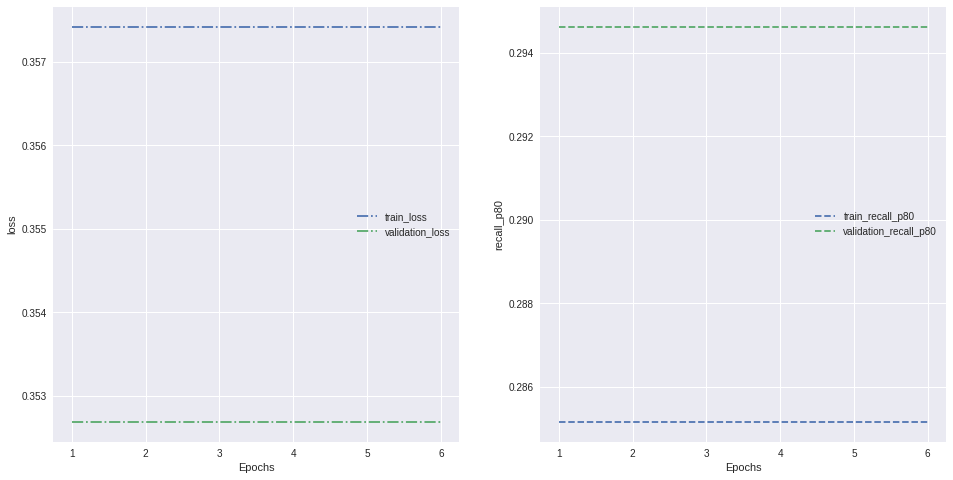

tumorCategory  glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision     0.0         0.0  ...   0.18408    0.046020      0.033885
1        recall     0.0         0.0  ...   0.18408    0.250000      0.184080
2      f1-score     0.0         0.0  ...   0.18408    0.077731      0.057235
3       support   100.0       115.0  ...   0.18408  402.000000    402.000000

[4 rows x 8 columns]


Done running model-1: BaseModelNew-mean_squared_error-Laplacian time: 239.6018293510001s




Image pre-processing for function: Laplacian and running all models
Pre-Processing raw image arrays with function to Laplacian

2. fittig model BaseModelNew-kl_divergence-Laplacian - PreProcName: Laplacian 
Epoch 1/250
144/144 [==============================] - 35s 232ms/step - loss: 13.1611 - accuracy: 0.6133 - AUC: 0.4756 - precision_r50: 0.2266 - precision_r63: 0.2266 - precision_r80: 0.2266 - recall_p50: 0.2266 - recall_p63: 0.2266 - recall_p80: 0.2266 - val_loss: 12.8218 - val_accuracy: 0.6023 - val_AUC: 0.4520 - val_precision_r50: 0.2045 - val_precision_r63: 0.2045 - val_precision_r80: 0.2045 - val_recall_p50: 0.2045 - val_recall_p63: 0.2045 - val_recall_p80: 0.2045
Epoch 2/250
144/144 [==============================] - 32s 220ms/step - loss: 13.1402 - accuracy: 0.5924 - AUC: 0.4392 - precision_r50: 0.1848 - precision_r63: 0.1848 - precision_r80: 0.1848 - recall_p50: 0.1848 - recall_p63:

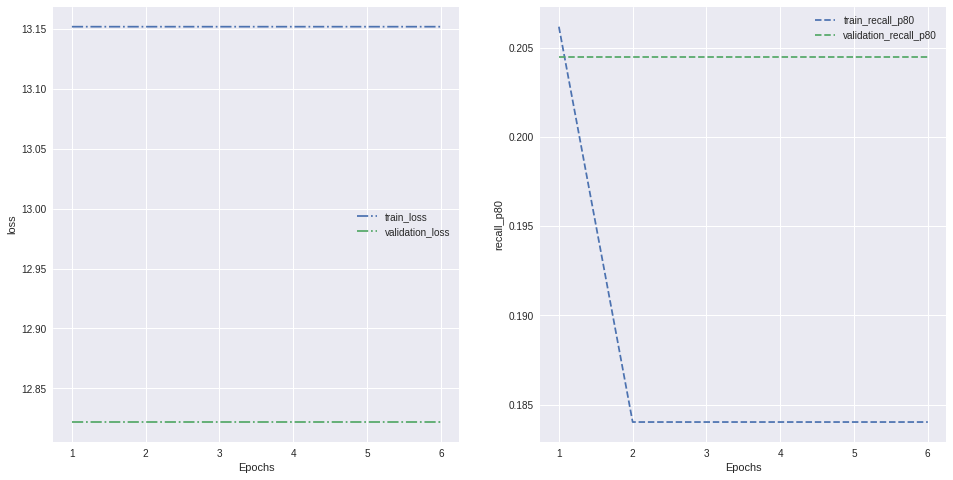

tumorCategory  glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision     0.0    0.313433  ...  0.293532    0.153755      0.174438
1        recall     0.0    0.365217  ...  0.293532    0.259446      0.293532
2      f1-score     0.0    0.337349  ...  0.293532    0.188447      0.213564
3       support   100.0  115.000000  ...  0.293532  402.000000    402.000000

[4 rows x 8 columns]


Done running model-2: BaseModelNew-kl_divergence-Laplacian time: 238.73515403200008s




Image pre-processing for function: Laplacian and running all models
Pre-Processing raw image arrays with function to Laplacian

3. fittig model BaseModelNew-categorical_crossentropy-Laplacian - PreProcName: Laplacian 
Epoch 1/250
144/144 [==============================] - 35s 230ms/step - loss: 49612401445.0759 - accuracy: 0.6690 - AUC: 0.5549 - precision_r50: 0.3380 - precision_r63: 0.3380 - precision_r80: 0.3380 - recall_p50: 0.3380 - recall_p63: 0.3380 - recall_p80: 0.3380 - val_loss: 953841856.0000 - val_accuracy: 0.7955 - val_AUC: 0.7422 - val_precision_r50: 0.5910 - val_precision_r63: 0.5910 - val_precision_r80: 0.5910 - val_recall_p50: 0.5910 - val_recall_p63: 0.5910 - val_recall_p80: 0.5910
Epoch 2/250
144/144 [==============================] - 31s 215ms/step - loss: 521373213.1310 - accuracy: 0.8527 - AUC: 0.8164 - precision_r50: 0.7053 - precision_r63: 0.7053 - precision_r80: 0.7053 - re

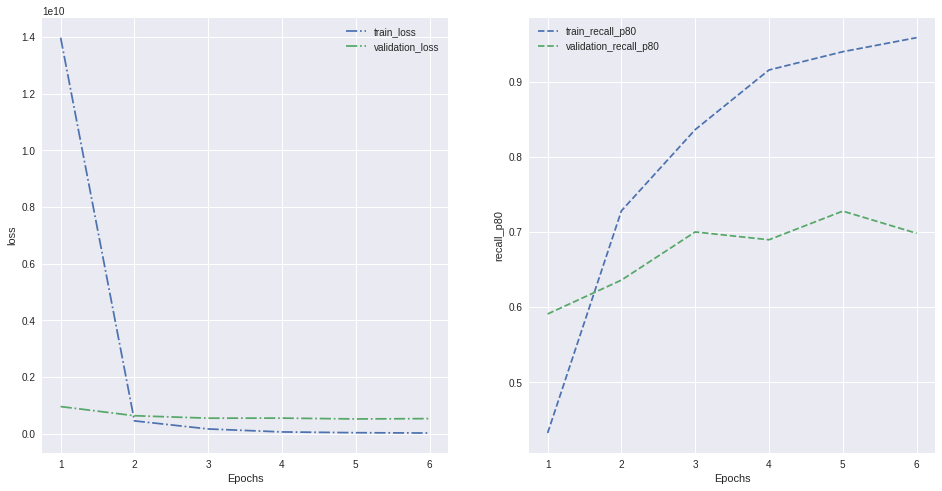

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.571429    0.583333  ...  0.549751    0.560761      0.559494
1        recall    0.360000    0.426087  ...  0.549751    0.548710      0.549751
2      f1-score    0.441718    0.492462  ...  0.549751    0.537316      0.535773
3       support  100.000000  115.000000  ...  0.549751  402.000000    402.000000

[4 rows x 8 columns]


Done running model-3: BaseModelNew-categorical_crossentropy-Laplacian time: 237.65362566999988s





TypeError: ignored

In [ ]:
import keras
from keras.models import Model
from timeit import default_timer as timer
importlib.reload(btc) # during refactorings
# Check effect of different losses on classification:
loss_kl_divergenge = keras.losses.KLDivergence(name ='kl_divergence') # name ='kl_divergence'
loss_mse = keras.losses.MeanSquaredError(name='mean_squared_error') # name='mean_squared_error'
loss_cat_cross_entropy = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy') # name='categorical_crossentropy'
# add different Evaluation metrics
eval_accuracy = keras.metrics.Accuracy(name='accuracy') # name='accuracy'
eval_auc = keras.metrics.AUC(multi_label=False,label_weights=list(classWeightsDict.values()),name='AUC')
eval_recall_p50 = keras.metrics.Recall(name='recall_p50',thresholds=0.5) # recall at precision 0.5 (default)
eval_recall_p63 = keras.metrics.Recall(name='recall_p63',thresholds=1-1/np.e) # recall at precision 1-1/e see https://www.quora.com/What-is-the-meaning-of-1-1-e-approximation
eval_recall_p80 = keras.metrics.Recall(name='recall_p80',thresholds=0.8) # recall at precision 0.8
eval_precision_r50 = keras.metrics.Precision(name='precision_r50',thresholds=0.5) # precision at recall = 0.5 (default)
eval_precision_r63 = keras.metrics.Precision(name='precision_r63',thresholds=1-1/np.e) # precision at recall 1-1/e
eval_precision_r80 = keras.metrics.Precision(name='precision_r80',thresholds=0.8) # precision at recall 0.8
#optimizers 
adam = keras.optimizers.Adam(name='Adam',learning_rate=1e-4, decay=1e-6)
# SGD? AdamDelta?

# Train model and use early stopping
earlyStoppingRecall = keras.callbacks.EarlyStopping(monitor='val_recall_p80',
                                              min_delta= 0.005, 
                                              patience=5,
                                              restore_best_weights=True)

namedLossModels = {}
# Get model to use
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()
losses = [loss_mse,loss_kl_divergenge,loss_cat_cross_entropy]
metrics = [eval_accuracy,eval_auc,eval_precision_r50,eval_precision_r63,eval_precision_r80,eval_recall_p50,eval_recall_p63,eval_recall_p80]
for loss in losses:
    # base model without dropout, regularize, batchNorm was best for gioma recall
    model = btc.MyModel.getBaseModelNew(imageShape,loss=loss,optimizer=adam,metrics=metrics)
    name = 'BaseModelNew-'+ loss.name + '-Laplacian'
    namedLossModels[name] = model
modelNo = 0
namedLossHistories = {}
_st=timer()
for name,model in namedLossModels.items():
    modelNo = modelNo + 1
    st = timer()
    # the last part of the model name has the preProcName
    preProcName = name.split('-')[-1]
    print(f'\nImage pre-processing for function: {preProcName} and running all models')
    tr_x,tr_y,vl_x,vl_y,ts_x,ts_y,classLabels = btc.getTrainValTestData(
        trainImgs,trainLabels,tr_ix,vl_ix,testImgs,testLabels,preProcName=preProcName)
    # Fit model
    print(f'\n{modelNo}. fittig model {name} - PreProcName: {preProcName} ')        
    #class_weight=classWeightsDict not used
    namedLossHistories[name] = model.fit(tr_x,tr_y,batch_size=16,epochs=250,verbose=1,
                                         validation_data=(vl_x,vl_y),
                                         callbacks = earlyStoppingRecall)
    print(f'Time taken to fit : {timer()-st:.3f}s')
    # save model
    model.save(getModelPath(name+'.h5'))
    hist_df = pd.DataFrame(namedLossHistories[name].history)
    with open(getModelPath(name+'_history.csv'), mode='w') as fh:
        hist_df.to_csv(fh)
    print(f'Saved model and history to {getModelPath(name)}')
    print(f'fitted model {name} (No ClassWeights)')
    print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
    btc.plotAccuracyAndLoss(namedLossHistories[name],getFigurePath(name+'_lossAccuracy.png'),varNames=['loss','recall_p80'])
    clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
    display(clfRepDf)
    clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
    print(f'\nDone running model-{modelNo}: {name} time: {timer()-st}s')
    print('\n\n')
    print('='*100)
    #done for one model-name
#Done if run_models condition
print(f'\nDone running all models for all pre-proc functions time: {timer()-_st}s')


## **Insight for  choice of loss functions, metrics**
- Of the different loss functions 
  - for ***Z-Scored images*** `kl-divergence`, which is a measure of similarity or relative-entropy between the distributions of true-labels and predicted-labels, gives best ***recall*** for glioma, as well as other tumor categories
  - for ***Laplacian images*** `categorical-crossentropy`, which is a measure of total entropy between distributions of true-labels and predicted-labels, gives best ***recall*** for glioma, as well as other tumor categories
  

|image-preProcess| loss-function | glioma | meningioma | no_tumor | pituitary | accuracy |
|:---:| ---:|:---:|:---:|:---:|:---:|:---:|
| *Laplacian*| **categorical-crossentropy** | **0.3600** | **0.4261** | **0.8142** | **0.5946** | **0.5498** |
| *Z-Score*| **kl-divergence** | **0.2700** | **0.7739** | **0.5841** | **0.5405** | **0.5522** |
| *Z-Score*| categorical-crossentropy | 0.1200	| 0.2870 | 0.8230 | 0.4054 | 0.4179 |
| *Z-Score* |mean-squared-error| 0.06000 | 0.6261 | 0.5310 | 0.5676 | 0.4478 |	



## **Does fixing dataset imbalance for tumor categories affect performance?**

In [ ]:
#!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE
importlib.reload(btc)
imageShape=(256,256,1)
# Read image data
trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
print('Label distribution before SMOTE')
display(btc.getLabelDistributionDf({'train':trainLabels}))

#use SMOTE
smote = SMOTE()
tempIdx = np.reshape(trainLabels.index,(-1,1))
trainIdxSmote, trainLabelsSmote = smote.fit_resample(tempIdx, trainLabels)
# print('Label distribution *After* SMOTE')
# display(btc.getLabelDistributionDf({'trainSMOTE':trainLabelsSmote}))
# confirmed that the indexes are correctly referenced 
trainIdxSmoteDf = pd.DataFrame(trainIdxSmote)
trainIdxSmoteDf.columns=['trainIdxSmote']
# trnLabSm = trainLabels[trainIdxSmoteDf['trainIdxSmote']]
display(btc.getLabelDistributionDf({'trainLabelSMOTE':trainLabels[trainIdxSmoteDf['trainIdxSmote']]}))


Reading HDF5 file ./DataSetBrainTumor/Training_256.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_256.h5
Label distribution before SMOTE


train  trainFraction
glioma       829.0       0.287747
meningioma   830.0       0.288094
no_tumor     395.0       0.137105
pituitary    827.0       0.287053
Total       2881.0       1.000000

trainLabelSMOTE  trainLabelSMOTEFraction
glioma                830.0                     0.25
meningioma            830.0                     0.25
no_tumor              830.0                     0.25
pituitary             830.0                     0.25
Total                3320.0                     1.00

Train images shape: (2656, 256, 256, 1), train labels : (2656, 4)
Val images shape: (664, 256, 256, 1), val labels : (664, 4)

0. fittig model BaseModel-L2Regularize-SMOTE-ZScore - PreProcName: ZScore 
Time taken to fit : 75.303s
Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_07_BaseModel-L2Regularize-SMOTE-ZScore
fitted model BaseModel-L2Regularize-SMOTE-ZScore (No ClassWeights)
21/21 [==============================] - 6s 143ms/step - loss: 0.5009 - accuracy: 0.9443 - precision: 0.9457 - recall: 0.9443
Val Score: [0.5009147524833679, 0.9442770481109619, 0.9457013010978699, 0.9442770481109619]


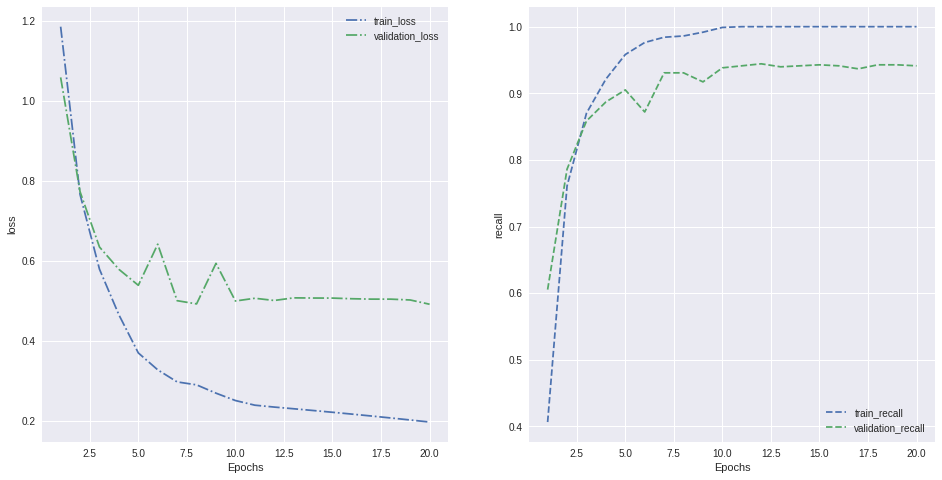

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.921053    0.737931  ...  0.753731    0.825023      0.806411
1        recall    0.350000    0.930435  ...  0.753731    0.734603      0.753731
2      f1-score    0.507246    0.823077  ...  0.753731    0.730090      0.730976
3       support  100.000000  115.000000  ...  0.753731  402.000000    402.000000

[4 rows x 8 columns]


Done running model-0 using *SMOTE* : BaseModel-L2Regularize-SMOTE-ZScore time: 91.65780041900143s



Train images shape: (2304, 256, 256, 1), train labels : (2304, 4)
Val images shape: (577, 256, 256, 1), val labels : (577, 4)

1. fittig model BaseModel-L2Regularize-NOSMOTE-ZScore - PreProcName: ZScore 
Time taken to fit : 75.497s
Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_07_BaseModel-L2Regularize-NOSMOTE-ZScore
fitted model BaseModel-L2Regularize-NOSMOTE-ZScore (No ClassWeights)
19/19 [==============================] - 3s 26ms/step - loss: 0.7087 - accuracy: 0.8995 - precision: 0.9007 - recall: 0.8960
Val Score: [0.7086999416351318, 0.8994800448417664, 0.9006968140602112, 0.8960138559341431]


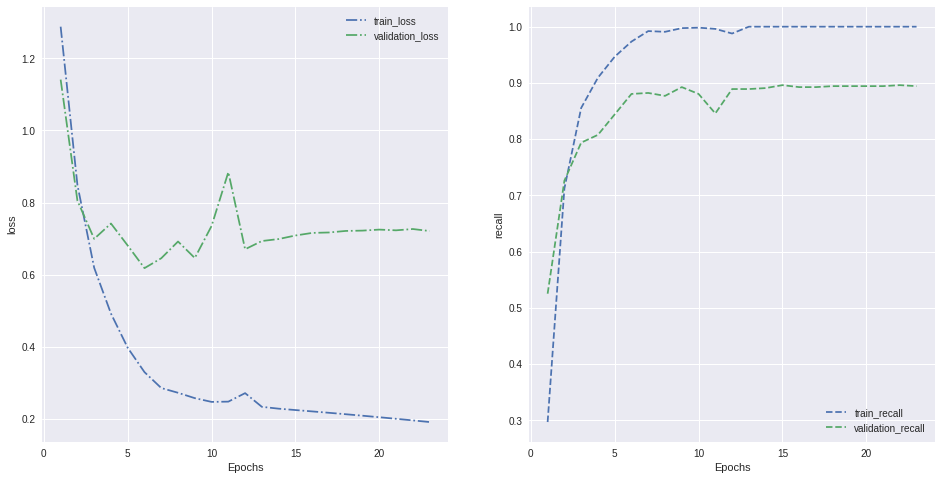

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.904762    0.673469  ...  0.721393    0.796570      0.776852
1        recall    0.380000    0.860870  ...  0.721393    0.701182      0.721393
2      f1-score    0.535211    0.755725  ...  0.721393    0.702233      0.703867
3       support  100.000000  115.000000  ...  0.721393  402.000000    402.000000

[4 rows x 8 columns]


Done running model-1 using No Smote : BaseModel-L2Regularize-NOSMOTE-ZScore time: 88.17319580699768s




Done running all models for all pre-proc functions time: 179.83262059099798s


In [ ]:
import keras
from keras.models import Model
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
importlib.reload(btc) # during refactorings
# Get model to use
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()

# Train model and use early stopping
earlyStoppingAccuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta= 0.001, 
                                              patience=8,
                                              restore_best_weights=True)
#use SMOTE and no smote to test model

models={}
models['BaseModel-L2Regularize-SMOTE-ZScore'] = btc.MyModel.getBaseModel(imageShape,strategy,numClasses=4,l2Lambda=0.0002)
models['BaseModel-L2Regularize-NOSMOTE-ZScore'] = btc.MyModel.getBaseModel(imageShape,strategy,numClasses=4,l2Lambda=0.0002)
# same model but input is different for training
modelHistories = {}
_st = timer()
modelNo = -1
for name,model in models.items():
    st = timer()
    modelNo = modelNo + 1
    preProcName = 'ZScore' # always use ZScore
    # get train-val split and run preprocessing
    
    if name.find('NOSMOTE') > -1:
        smoteProc = 'No Smote'
        tx,vx,ty,vy = train_test_split(trainImgs,trainLabels,test_size=0.2,random_state=19)
    else:
        smoteProc = '*SMOTE*'
        smote = SMOTE()
        tempIdx = np.reshape(trainLabels.index,(-1,1))
        trainIdxSmote, trainLabelsSmote = smote.fit_resample(tempIdx, trainLabels)
        trainIdxSmoteDf = pd.DataFrame(trainIdxSmote)
        trainIdxSmoteDf.columns=['trainIdxSmote']
        # print('Label distribution *After* SMOTE')
        # display(btc.getLabelDistributionDf({'trainSMOTE':trainLabelsSmote}))
        # confirmed that the indexes are correctly referenced 
        tdx = trainIdxSmoteDf['trainIdxSmote'].values
        tLabs = trainLabels[tdx]
        tImgs = trainImgs[tdx]
        tx,vx,ty,vy = train_test_split(tImgs,tLabs,test_size=0.2,random_state=19) 

    # prepare X
    tr_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in tx]),axis=3)
    vl_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in vx]),axis=3)
    ts_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in testImgs]),axis=3)
    # prepare Y
    tumorCategoryOHE = OneHotEncoder()
    tr_y = tumorCategoryOHE.fit_transform(ty.values.reshape(-1, 1)).toarray()
    vl_y = tumorCategoryOHE.transform(vy.values.reshape(-1, 1)).toarray()
    ts_y = tumorCategoryOHE.transform(testLabels.values.reshape(-1,1)).toarray()

    classLabels = [x.replace('x0_','') for x in tumorCategoryOHE.get_feature_names()]

    print(f'Train images shape: {tr_x.shape}, train labels : {tr_y.shape}')
    print(f'Val images shape: {vl_x.shape}, val labels : {vl_y.shape}')
    # Fit model
    print(f'\n{modelNo}. fittig model {name} - PreProcName: {preProcName} ')        
    #class_weight=classWeightsDict not used
    modelHistories[name] = model.fit(tr_x,tr_y,batch_size=16,epochs=250,verbose=0,
                                         validation_data=(vl_x,vl_y),
                                         callbacks = earlyStoppingAccuracy)
    print(f'Time taken to fit : {timer()-st:.3f}s')
    # save model
    model.save(getModelPath(name+'.h5'))
    hist_df = pd.DataFrame(modelHistories[name].history)
    with open(getModelPath(name+'_history.csv'), mode='w') as fh:
        hist_df.to_csv(fh)
    print(f'Saved model and history to {getModelPath(name)}')
    print(f'fitted model {name} (No ClassWeights)')
    print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
    btc.plotAccuracyAndLoss(modelHistories[name],getFigurePath(name+'_lossAccuracy.png'),varNames=['loss','recall'])
    clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
    display(clfRepDf)
    clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
    print(f'\nDone running model-{modelNo} using {smoteProc} : {name} time: {timer()-st}s')
    print('\n\n')
    print('='*100)
    #done for one model-name
#Done if run_models condition
print(f'\nDone running all models for all pre-proc functions time: {timer()-_st}s')




In [ ]:
models['BaseModel-L2Regularize-SMOTE-ZScore'].summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 256, 256, 32)      320       
_________________________________________________________________
leaky_re_lu_276 (LeakyReLU)  (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_277 (LeakyReLU)  (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 64, 64, 64)        0  

## **Use suggested class-weights without SMOTE**

Reading HDF5 file ./DataSetBrainTumor/Training_256.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_256.h5
Train images shape: (2304, 256, 256, 1), train labels : (2304, 4)
Val images shape: (577, 256, 256, 1), val labels : (577, 4)

0. fittig model BaseModel-L2Regularize-NOSMOTE-ZScore_weighted - PreProcName: ZScore 
Time taken to fit : 77.517s
Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_08_BaseModel-L2Regularize-NOSMOTE-ZScore_weighted
fitted model BaseModel-L2Regularize-NOSMOTE-ZScore_weighted (No ClassWeights)
19/19 [==============================] - 3s 26ms/step - loss: 0.7153 - accuracy: 0.9099 - precision: 0.9115 - recall: 0.9099
Val Score: [0.7152761816978455, 0.909878671169281, 0.9114583134651184, 0.909878671169281]


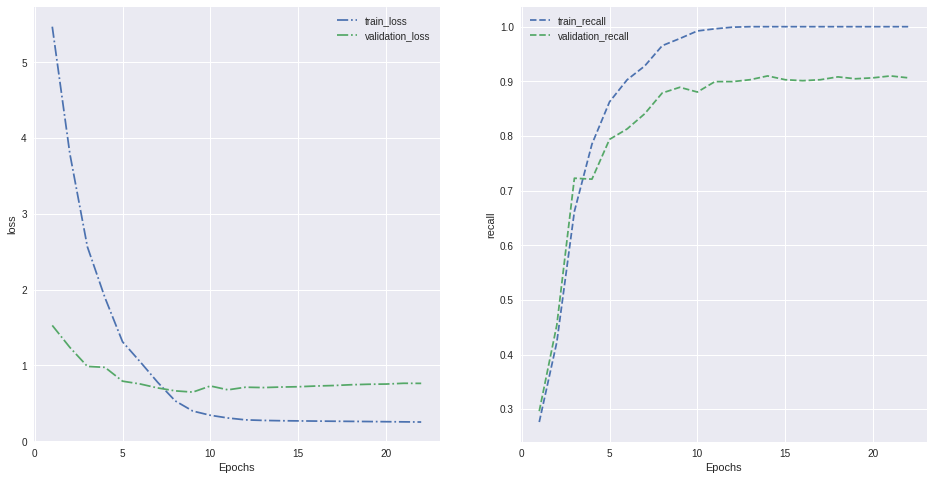

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.846154    0.660377  ...  0.716418    0.788138      0.767278
1        recall    0.330000    0.913043  ...  0.716418    0.692757      0.716418
2      f1-score    0.474820    0.766423  ...  0.716418    0.688485      0.691870
3       support  100.000000  115.000000  ...  0.716418  402.000000    402.000000

[4 rows x 8 columns]


Done running model-0 using No Smote : BaseModel-L2Regularize-NOSMOTE-ZScore_weighted time: 96.192253983s
Used class_weight= {0: 20, 1: 4, 2: 1, 3: 1.5}




Done running all models for all pre-proc functions time: 96.19317045599996s


In [ ]:
# due to piecemeal testing of each code-block
import keras
from keras.models import Model
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
importlib.reload(btc) # during refactorings
# Get model to use
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()

# Train model and use early stopping
earlyStoppingAccuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta= 0.001, 
                                              patience=8,
                                              restore_best_weights=True)
imageShape=(256,256,1)
# Read image data
trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
models={}
models['BaseModel-L2Regularize-NOSMOTE-ZScore_weighted'] = btc.MyModel.getBaseModel(imageShape,strategy,numClasses=4,l2Lambda=0.0002)
# same model but input is different for training
modelHistories = {}
_st = timer()
modelNo = -1

for name,model in models.items():
    st = timer()
    modelNo = modelNo + 1
    preProcName = 'ZScore' # always use ZScore
    # get train-val split and run preprocessing
    smoteProc = 'No Smote'
    tx,vx,ty,vy = train_test_split(trainImgs,trainLabels,test_size=0.2,random_state=19)
    # prepare X
    tr_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in tx]),axis=3)
    vl_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in vx]),axis=3)
    ts_x = np.expand_dims(np.array([btc.imZsc(xx) for xx in testImgs]),axis=3)
    # prepare Y
    tumorCategoryOHE = OneHotEncoder()
    tr_y = tumorCategoryOHE.fit_transform(ty.values.reshape(-1, 1)).toarray()
    vl_y = tumorCategoryOHE.transform(vy.values.reshape(-1, 1)).toarray()
    ts_y = tumorCategoryOHE.transform(testLabels.values.reshape(-1,1)).toarray()

    classLabels = [x.replace('x0_','') for x in tumorCategoryOHE.get_feature_names()]
    # as provided by Program office....as
    # [0:20,1:4,2:1,1,3:1.5]
    classWeightsDict = {0:20,1:4,2:1,3:1.5}

    print(f'Train images shape: {tr_x.shape}, train labels : {tr_y.shape}')
    print(f'Val images shape: {vl_x.shape}, val labels : {vl_y.shape}')
    # Fit model
    print(f'\n{modelNo}. fittig model {name} - PreProcName: {preProcName} ')        
    #class_weight=classWeightsDict not used
    modelHistories[name] = model.fit(tr_x,tr_y,batch_size=16,epochs=250,verbose=0,
                                     class_weight=classWeightsDict,
                                     validation_data=(vl_x,vl_y),
                                     callbacks = earlyStoppingAccuracy)
    print(f'Time taken to fit : {timer()-st:.3f}s')
    # save model
    model.save(getModelPath(name+'.h5'))
    hist_df = pd.DataFrame(modelHistories[name].history)
    with open(getModelPath(name+'_history.csv'), mode='w') as fh:
        hist_df.to_csv(fh)
    print(f'Saved model and history to {getModelPath(name)}')
    print(f'fitted model {name} (No ClassWeights)')
    print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
    btc.plotAccuracyAndLoss(modelHistories[name],getFigurePath(name+'_lossAccuracy.png'),varNames=['loss','recall'])
    clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
    display(clfRepDf)
    clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
    print(f'\nDone running model-{modelNo} using {smoteProc} : {name} time: {timer()-st}s')
    print(f'Used class_weight= {classWeightsDict}')
    print('\n\n')
    print('='*100)
    #done for one model-name
#Done if run_models condition
print(f'\nDone running all models for all pre-proc functions time: {timer()-_st}s')

## **Insight using Program suggested weights for training**
- After training with suggested weights `class_weight= {0: 20, 1: 4, 2: 1, 3: 1.5}`, the recall did not show any improvements from base model with no weights for clioma recall.

|Smote operation| glioma | meningioma | no_tumor | pituitary | accuracy |
|:---:|:---:|:---:|:---:|:---:|:---:|
| *weights NOSMOTE* | 0.3300 | 0.9130 | 0.9469 | 0.5811 | 0.7164 |
| *no weights no SMOTE* | **0.3800** | **0.8609** | **0.9558** | **0.6081** | **0.7213** |


## **Insight for fixing dataset imbalance for tumor categories and performance**
- We have an uneven distribution of tumor categories in the training dataset. In order to generate a balanced distribution of tumor categories, `imblearn.over_sampling.SMOTE()` was used. After `SMOTE` call the distribution of classes were as follows, although, the number of samples for categories are duplicated to get balanced distribution: 

|Tumor Category| train	| trainFraction |trainSMOTE	| trainSMOTEFraction |
|:---:|:---:|:---:|:---:|:---:|
| glioma	| 829 | 0.288| 830 | 0.25 |
| meningioma | 830 | 0.288 | 830 | 0.25 |
| **no_tumor**	| **395** | **0.137** | **830** | **0.25** |
| pituitary	|827 | 0.287 | 830 | 0.25 |
| Total	| 2881 | 1.000| 3320 | 1.00 | 

- Using ***Z-Scored images*** with`categorical-crossentropy` and `L2-Regularization`, on `BaseModel` we observed a small ***fall** in the ***recall*** for glioma, suggesting that balancing the tumor categories resulted in a *lowered* or no gain in improving ***recall*** for glioma.
- with SMOTE, while glioma recall was lower, recall for memingioma, no_tumor, and pituitary were are reatively higher. Accuray was also higher when using SMOTE.
  

|Smote operation| glioma | meningioma | no_tumor | pituitary | accuracy |
|:---:|:---:|:---:|:---:|:---:|:---:|
| *SMOTE* | 0.3500 | 0.9304 | 0.9823 | 0.6757 | 0.7537 |
| *no SMOTE* | **0.3800** | **0.8609** | **0.9558** | **0.6081** | **0.7213** |

**Based on all the previous analyses the following criteria are used for the final model building, training and predictions:**
- **CNN Model**: For all layers, if not specified stride=1, padding='same' and kernel_regularizer=0.0002

| Layer | Name | Properties | 
|:---:|:---:|:---:|
| 1 | Input Layer | (256, 256, 1) | 
| 2 | Conv 2D | filters=32, kernel size = [3,3] | 
| 3 | LeakyReLU | alpha=0.1 | 
| 4 | Max Pooling | pool_size=2 | 
| 5 | Conv 2D | filters=64, kernel size = [3,3] | 
| 6 | LeakyReLU | alpha=0.1 | 
| 7 | Max Pooling | pool_size=2 | 
| 8 | Conv 2D | filters=64, kernel size = [3,3] | 
| 9 | LeakyReLU | alpha=0.1 | 
| 10 | Max Pooling | pool_size=2 | 
| 11 | Conv 2D | filters=32, kernel size = [5,5] | 
| 12 | LeakyReLU | alpha=0.1 | 
| 13 | Max Pooling | pool_size=2 |
| 14 | Conv 2D | filters=16, kernel size = [5,5] | 
| 15 | LeakyReLU | alpha=0.1 | 
| 16 | Max Pooling | pool_size=2 |
| 18 | Flatten |  |
| 19 | Dense | filters=512 |
| 20 | LeakyReLU | alpha=0.1 | 
| 21 | Dense | filters=256 |
| 22 | LeakyReLU | alpha=0.1 | 
| 23 | Dense | filters=4 |
| 22 | Softmax | | 
| 23 | Output | 4 classes (0=glioma, 1=meningioma, 2=no_tumor, 3=pituitary)  | 

- **Loss function**: `categorical-crossentropy` was used as it gave more consistient results than `kl-divergence`
- **Metrics**: `keras.metrics.Recall` was used kto evaluate model perfomance, seice the aim was to increase the `sensitivity` metric of model performance since the overall `accuracy` of tested models were generally in a similar range, but the recall varied most.
- **Early stopping**: Early stopping criteria of assessing `val_accuracy` with min-delta improvement of 0.005 over 8 epochs was used terminate training.
- **Input and TestImages**: Both raw and Z-scored data for each image in the training and test datasets were used for final model with batch normalization and L2-regularization
- **Class imbalance**: Training dataset is balanced with `SMOTE` to get even distribution of images across all tumor categories.
- **Classification report**: classification report is wued to report on prediction for testing images. The `confusion-matrix` for multi-class classification is visualized as heatmaps.







## **Experiments with Transfer learning using models pre-trained on *imagenet***

In [ ]:

def getTop(baseOutput):
        ## top = base.output
        top = GlobalMaxPooling2D()(baseOutput)
        top = Flatten(name="flatten")(top)
        top = Dense(512, activation="relu")(top)
        top = Dropout(0.5)(top)
        top = Dense(128, activation="relu")(top)
        top = Dropout(0.5)(top)
        top = Dense(4, activation="softmax")(top)
        return top

def getBottom(name,inputShape):
    if name == 'vgg16':
        return keras.applications.VGG16(include_top=False,input_shape=inputShape)
    elif name == 'xception':
        return keras.applications.Xception(include_top=False,input_shape=inputShape)
    elif name == 'inceptionResNetV2':
        return keras.applications.InceptionResNetV2(include_top=False,input_shape=inputShape)
    elif name == 'nasNetLarge':
        return keras.applications.NASNetLarge(include_top=False,input_shape=inputShape)
    elif name == 'nasNetMobile':
        return keras.applications.NASNetMobile(include_top=False,input_shape=inputShape)
    else:
        assert 0==1, f'Model {name} not implemented'

def getImagenetModel(modelName,imageShape,strategy):
    with strategy.scope():
        bottom = getBottom(modelName,imageShape) 
        #get top layers, inout will be output of bottom
        top = getTop(bottom.output)
        #freeze layers in vggBase model
        for layer in bottom.layers:
          layer.trainable = False 

        model = Model(inputs=bottom.input,outputs=top)
        model.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=1e-4, decay=1e-5),
                      metrics=['accuracy',
                                keras.metrics.Precision(name='precision'),
                                keras.metrics.Recall(name='recall')])
        return model


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model,Sequential
import keras
import numpy as np
import tensorflow as tf

importlib.reload(btc)
# ensure each image is RGB channels
# for all imagenets we need 224x224x3 if no manipulation is needed
imageShape=(224,224,3)
# Read image data
trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
# convert grayscale images to RGB after applying ZScore and scaling between 0-1
trainImgs = np.array([btc.imNorm(btc.imZsc(xx)) for xx in trainImgs])
trainImgs = np.repeat(np.expand_dims(trainImgs, axis=3), 3, axis=3)
testImgs = np.array([btc.imNorm(btc.imZsc(xx)) for xx in testImgs])
testImgs = np.repeat(np.expand_dims(testImgs, axis=3), 3, axis=3)
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()


Reading HDF5 file ./DataSetBrainTumor/Training_224.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_224.h5



Transfer learning for model vgg16 

Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_08_vgg16_TxLearn-NormZScore
fitted model vgg16_TxLearn-NormZScore (No ClassWeights)
19/19 [==============================] - 7s 42ms/step - loss: 0.4511 - accuracy: 0.8319 - precision: 0.8381 - recall: 0.8076
Val Score: [0.45111212134361267, 0.8318890929222107, 0.8381295204162598, 0.8076256513595581]


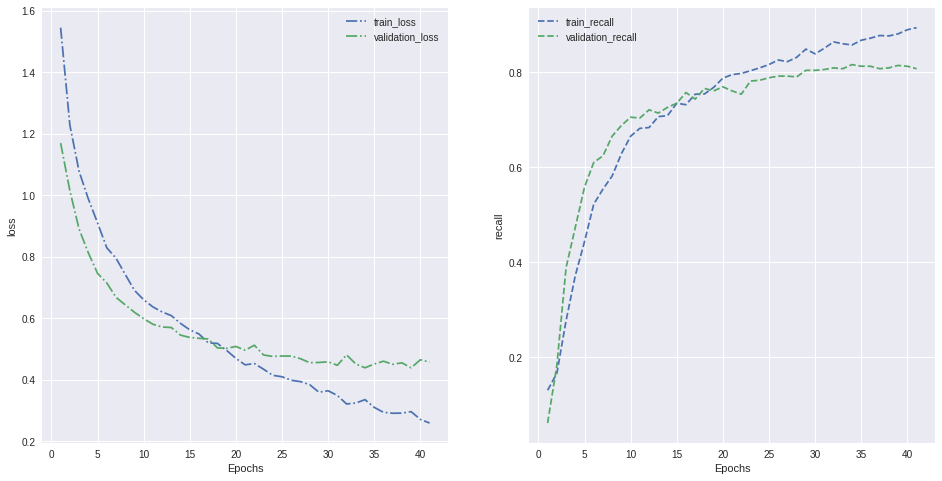

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.693878    0.615385  ...  0.723881    0.751095      0.734003
1        recall    0.340000    0.834783  ...  0.723881    0.722182      0.723881
2      f1-score    0.456376    0.708487  ...  0.723881    0.715513      0.707346
3       support  100.000000  115.000000  ...  0.723881  402.000000    402.000000

[4 rows x 8 columns]


Done running model-1: vgg16_TxLearn-NormZScore time: 148.79102542400142s

Transfer learning for model xception 

Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_08_xception_TxLearn-NormZScore
fitted model xception_TxLearn-NormZScore (No ClassWeights)
19/19 [==============================] - 5s 40ms/step - loss: 0.3137 - accuracy: 0.9064 - precision: 0.9133 - recall: 0.8943
Val Score: [0.3137166202068329, 0.9064124822616577, 0.913274347782135, 0.8942807912826538]


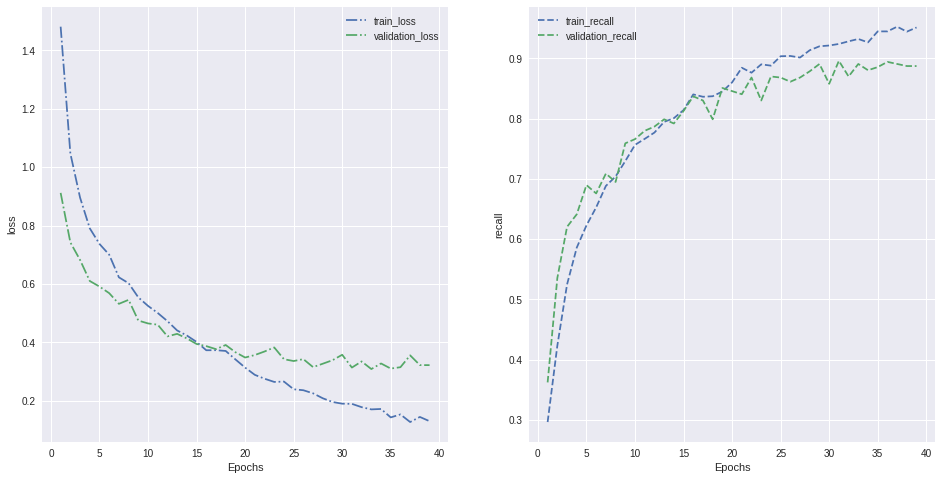

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.744186    0.622754  ...  0.723881    0.770934      0.753057
1        recall    0.320000    0.904348  ...  0.723881    0.700311      0.723881
2      f1-score    0.447552    0.737589  ...  0.723881    0.693904      0.698263
3       support  100.000000  115.000000  ...  0.723881  402.000000    402.000000

[4 rows x 8 columns]


Done running model-2: xception_TxLearn-NormZScore time: 185.60530344299696s

Transfer learning for model inceptionResNetV2 

Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_08_inceptionResNetV2_TxLearn-NormZScore
fitted model inceptionResNetV2_TxLearn-NormZScore (No ClassWeights)
19/19 [==============================] - 9s 74ms/step - loss: 0.4410 - accuracy: 0.8388 - precision: 0.8520 - recall: 0.8180
Val Score: [0.4410132169723511, 0.8388214707374573, 0.8519856333732605, 0.8180242776870728]


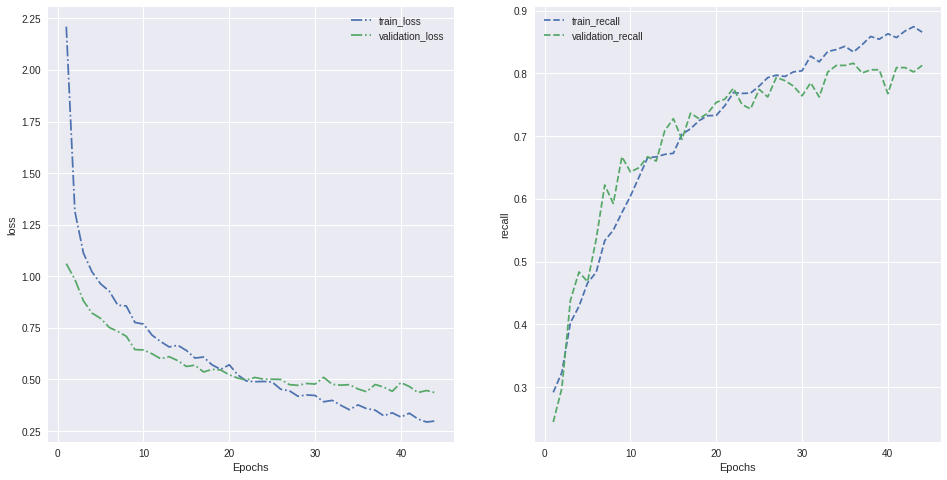

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.730769    0.617284  ...  0.738806    0.771615      0.756588
1        recall    0.380000    0.869565  ...  0.738806    0.728291      0.738806
2      f1-score    0.500000    0.722022  ...  0.738806    0.727148      0.724775
3       support  100.000000  115.000000  ...  0.738806  402.000000    402.000000

[4 rows x 8 columns]


Done running model-3: inceptionResNetV2_TxLearn-NormZScore time: 647.3960001369996s

Transfer learning for model nasNetMobile 

19996672/19993432 [==============================] - 0s 0us/step
Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_08_nasNetMobile_TxLearn-NormZScore
fitted model nasNetMobile_TxLearn-NormZScore (No ClassWeights)
19/19 [==============================] - 9s 53ms/step - loss: 0.4058 - accuracy: 0.8510 - precision: 0.8546 - recall: 0.8354
Val Score: [0.4057867228984833, 0.850953221321106, 0.8546099066734314, 0.835355281829834]


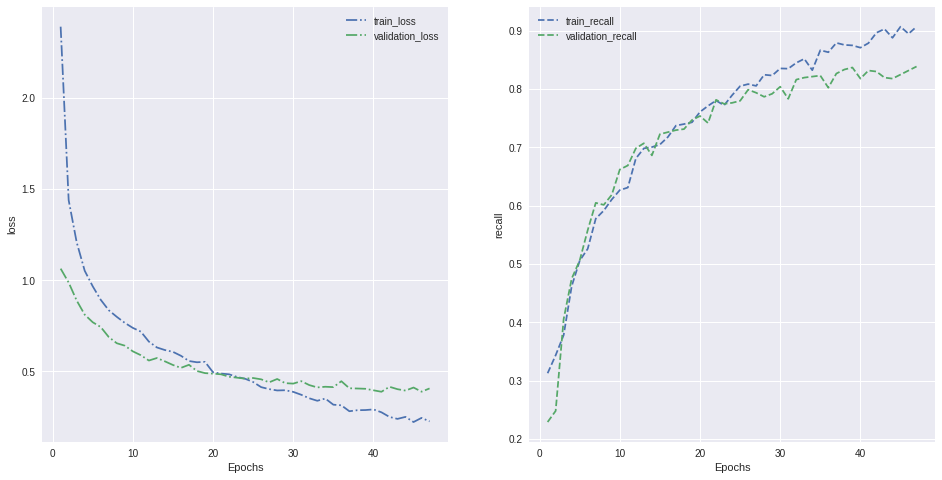

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.732143    0.622642  ...  0.716418    0.760232      0.740856
1        recall    0.410000    0.860870  ...  0.716418    0.704616      0.716418
2      f1-score    0.525641    0.722628  ...  0.716418    0.709211      0.706100
3       support  100.000000  115.000000  ...  0.716418  402.000000    402.000000

[4 rows x 8 columns]


Done running model-4: nasNetMobile_TxLearn-NormZScore time: 471.0212767369994s


In [ ]:
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

# common for all models
# Train model and use early stopping
earlyStoppingAccuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              min_delta= 0.0001, 
                                              patience=8,
                                              restore_best_weights=True)
smoteProc ='NoSmote'
tr_x,vl_x,ty,vy = train_test_split(trainImgs,trainLabels,test_size=0.2,random_state=19)
ts_x = testImgs

tumorCategoryOHE = OneHotEncoder()
tr_y = tumorCategoryOHE.fit_transform(ty.values.reshape(-1, 1)).toarray()
vl_y = tumorCategoryOHE.transform(vy.values.reshape(-1, 1)).toarray()
ts_y = tumorCategoryOHE.transform(testLabels.values.reshape(-1,1)).toarray()

# class labels
classLabels = [x.replace('x0_','') for x in tumorCategoryOHE.get_feature_names()]
# as provided by Program office....as
# [0:20,1:4,2:1,1,3:1.5]
classWeightsDict = {0:20,1:4,2:1,3:1.5}

_st=timer()
modelNo = 0
# 'nasNetLarge' needs (331, 331, 3) shape
imagenetModelNames = ['vgg16','xception','inceptionResNetV2','nasNetMobile']
for modelName in imagenetModelNames:
    st=timer()
    modelNo = modelNo + 1
    # fit model
    print(f'\nTransfer learning for model {modelName} \n')
    model = getImagenetModel(modelName,imageShape,strategy)
    name = modelName+'_TxLearn-NormZScore'
    # fit model
    history = model.fit(tr_x,tr_y,batch_size=16,epochs=250,verbose=0,
                                        validation_data=(vl_x,vl_y),
                                        callbacks = earlyStoppingAccuracy)
    model.save(getModelPath(name+'.h5'))
    hist_df = pd.DataFrame(history.history)
    with open(getModelPath(name+'_history.csv'), mode='w') as fh:
        hist_df.to_csv(fh)
    print(f'Saved model and history to {getModelPath(name)}')
    print(f'fitted model {name} (No ClassWeights)')
    print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
    btc.plotAccuracyAndLoss(history,getFigurePath(name+'_lossAccuracy.png'),varNames=['loss','recall'])
    clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
    display(clfRepDf)
    clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
    print(f'\nDone running model-{modelNo}: {name} time: {timer()-st}s')


## **Insights for experiments with Transfer learning using models pre-trained on *imagenet***

- Transfer learning for **NasNetMobile** gave the over best result for *glioma recall* followed by **InceptionResNetV2**, eventhough these architectures were primarily trained on ImageNet data. Only the top layers of these nets were trained during transfer learning.

|CNN Model| glioma | meningioma | no_tumor | pituitary | accuracy | time(s) |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| VGG16 | 0.3400 | 0.8348 | 0.8761 | 0.8378 | 0.7239 | 148.79 |
| Xception | 0.3200 | 0.9043 | 0.9823 | 0.5946 | 0.7239 | 185.61 |
| InceptionResNetV2 | 0.3800 | 0.8696 | 0.9204 | 0.7432 | 0.7388 | 647.40 |
| **NasNetMobile** | **0.4100** | **0.8609** | **0.8584** | **0.6892** | **0.7164** | 141.02 |


## **Does *data augmentation* improve performance on tumor classification?**

In [ ]:
from timeit import default_timer as timer
import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

imageShape = (256,256,1)
trainImgs,trainLabels,_ = loadImagesDataset(imageShape,'training')
testImgs,testLabels,_ = loadImagesDataset(imageShape,'testing')

print('******Data augmentation fails to run on TPU so have to use GPU only. This may be due to the way the iterator works')
if not 'strategy' in locals():
    strategy = btc.getCPUorGPUorTPUStrategy()


Reading HDF5 file ./DataSetBrainTumor/Training_256.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_256.h5
******Data augmentation fails to run on TPU so have to use GPU only. This may be due to the way the iterator works
Running on GPU: Number of accelerators  1


Pre-Processing raw image arrays with function to ZScore
Saved model and history to /content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_10_FinalBN_BrightnessOnlyt-BatchNormalize-ZScore
fitted model FinalBN_BrightnessOnlyt-BatchNormalize-ZScore (No ClassWeights)
19/19 [==============================] - 0s 11ms/step - loss: 0.9014 - accuracy: 0.6256 - precision: 0.8286 - recall: 0.4021
Val Score: [0.9013936519622803, 0.6256499290466309, 0.8285714387893677, 0.4020797312259674]


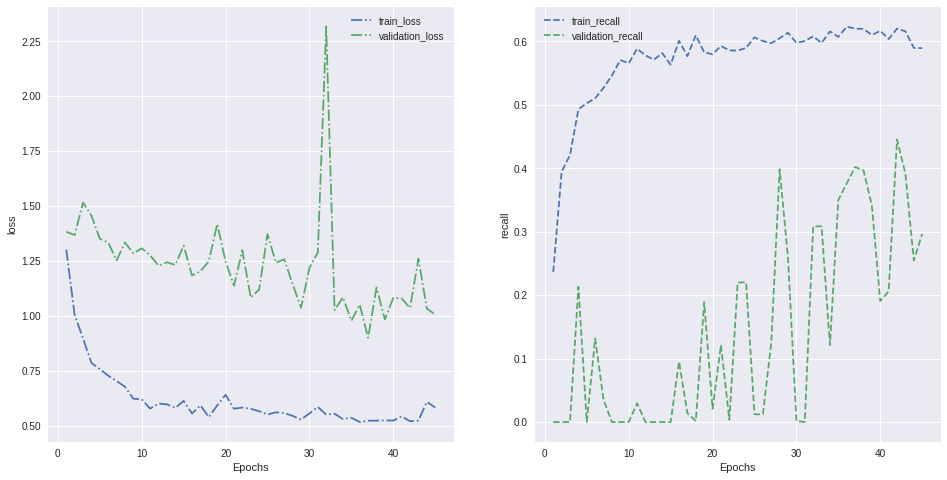

tumorCategory      glioma  meningioma  ...  accuracy   macro avg  weighted avg
0     precision    0.447368    0.530120  ...  0.539801    0.536649      0.546680
1        recall    0.340000    0.382609  ...  0.539801    0.560466      0.539801
2      f1-score    0.386364    0.444444  ...  0.539801    0.530164      0.527986
3       support  100.000000  115.000000  ...  0.539801  402.000000    402.000000

[4 rows x 8 columns]


Done running model-0: FinalBN_BrightnessOnlyt-BatchNormalize-ZScore time: 118.358817595s


In [ ]:
from timeit import default_timer as timer
importlib.reload(btc)
# train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=45,
#                                                           width_shift_range=0.3,
#                                                           height_shift_range=0.3,
#                                                           brightness_range=[-0.75,1.25],
#                                                           shear_range=20,
#                                                           zoom_range=[0.8,1.2],
#                                                           fill_mode='nearest',
#                                                           horizontal_flip=True)
#  Epoch 45/100
# 144/144 [==============================] - 11s 76ms/step - loss: 0.9577 - accuracy: 0.5490 - precision: 0.7628 - recall: 0.3835 - val_loss: 1.5075 - val_accuracy: 0.2340 - val_precision: 0.0952 - val_recall: 0.0035
# Epoch 46/100
# 144/144 [==============================] - 11s 76ms/step - loss: 0.9741 - accuracy: 0.5218 - precision: 0.7399 - recall: 0.3616 - val_loss: 1.4885 - val_accuracy: 0.1248 - val_precision: 0.1429 - val_recall: 0.0017
 
train_datagen = keras.preprocessing.image.ImageDataGenerator(brightness_range=[-0.75,1.25]) 
tr_ix,vl_ix,_,_ = btc.getTrainTestIndexes(trainLabels,testSplit=0.2)
tr_x,tr_y,vl_x,vl_y,ts_x,ts_y,classLabels = btc.getTrainValTestData(trainImgs,
                                            trainLabels,tr_ix,vl_ix,testImgs,testLabels,preProcName='ZScore')
earlyStoppingAccuracy = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        min_delta= 0.0001,patience=8,restore_best_weights=True)
modelNo = 0
name='FinalBN_BrightnessOnlyt-BatchNormalize-ZScore'
st=timer()
model = btc.MyModel.getBaseModel(imageShape,strategy,numClasses=4,bNorm=True)
history = model.fit(train_datagen.flow(tr_x,tr_y,shuffle=True,seed=19,batch_size=16),
                        epochs=100,verbose=0,validation_data=(vl_x,vl_y),callbacks=earlyStoppingAccuracy) 
model.save(getModelPath(name+'.h5'))
hist_df = pd.DataFrame(history.history)
with open(getModelPath(name+'_history.csv'), mode='w') as fh:
    hist_df.to_csv(fh)
print(f'Saved model and history to {getModelPath(name)}')
print(f'fitted model {name} (No ClassWeights)')
print(f'Val Score: {model.evaluate(vl_x, vl_y)}')
btc.plotAccuracyAndLoss(history,getFigurePath(name+'_lossAccuracy.png'),varNames=['loss','recall'])
clfRepDf = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
display(clfRepDf)
clfRepDf.to_csv(getModelPath(name+'_classifReport.csv'))
print(f'\nDone running model-{modelNo}: {name} time: {timer()-st}s')



## **Insight for if *data augmentation* improve performance on tumor classification**
- Data augmentation did not run on TPU, which maybe due to the the inaccessibilty of the flow iterator to the running TPU processes.
- Although, the recall for glioma is higher, the traces for training data for validation set show a very unstable behavior of the system when using data augmentation. The overall accuracy of the system is is low around 54%
- Data augmentation also has the disadvantage of not knowing the *on the fly* images producuced by the iterator during training. One way to overcome this is to first create the iterator and save the resulting augmented images, either in memory or to file(s) which comes with its own overhead for the *ROI*, hence data augmentation was not used in other model trainng and evaluations.

## **Create final models for recommendation**

- Train top 3 models with cross validation for recommendation. The choice of model and pre-processing are based on giloma recall and overall accuracy highlighted in table below.
- All models used ***categorical_crossentropy*** minimization although *KL-divergence* wss very slightly beneficial (1 percentage point) for Laplacian filter.
- For all models were evaluated on *accuracy* during training but also assessed for *precision* and *recall*. We filtered models for recall.
- Since the goal of the project is to improve the ability of the model to correctly identify patients with glioma, we wanted to minimize the *false-negatives*, we focussed the efforts on maximizing the ***recall*** or ***sensitivity*** of the model.
- Early stopping is based on *accuracy* metric gain of 0.05 percentage points for 8 epoch run. Compared to recall or precision accuracy simultaneously improved both recall and precesion of the model.


|*rank*| modelName |	imgPreProc | glioma | meningioma | no_tumor | pituitary | accuracy |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**1**|**BaseModel-BatchNorm-L2Regularize**|**Laplacian**|**0.37**|**0.87**|**0.98**|**0.78**|**0.76**|
|**2**|**BaseModel-BatchNorm-L2Regularize**|**Raw**|**0.37**|**0.87**|**0.97**|**0.80**|**0.76**|
|**3**|**BaseModel-BatchNorm**|**ZScore**|**0.35**|**0.88**|**1.00**|**0.68**|**0.74**|


In [ ]:
import keras
import sklearn
from timeit import default_timer as timer
importlib.reload(btc)

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                      min_delta= 0.0005,patience=8,restore_best_weights=True)

def getRecommendedModel(strategy,imageShape,recoNo=1):
    shape = imageShape
    kernelL2 = 0.00020
    if recoNo == 3:
      ############# recomendation #3
      # BaseModel-BatchNorm	ZScore	0.35	0.88	1.00	0.68	0.74
      modelName = 'Recommend_3-BaseModel-BatchNorm-'+'ZScore'
      model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True)
    elif recoNo == 2:
      ############ recomendation #2
      # BaseModel-BatchNorm-L2Regularize	Raw	0.37	0.87	0.97	0.80	0.76
      modelName = 'Recommend_2-BaseModel-BatchNorm-L2Regularize-'+'Raw'
      model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2)
    elif recoNo == 1:
      ############ recomendation #1
      # BaseModel-BatchNorm-L2Regularize	Laplacian 0.37	0.87	0.98	0.78	0.76
      modelName = 'Recommend_1-BaseModel-BatchNorm-L2Regularize-'+'Laplacian'
      model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2)
      
    return modelName,model

run_models = False # toggle back to not overwrite output
st = timer()
evalMetricsDf = None
classifReportDf = None
models = {}
histories = {}
if run_models: ## Just so we do not overwrite
    # Read image dataset
    imageShape = (256,256,1)
    trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
    testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
    # get tain and test split for validation
    tx_ix,vl_ix,classLabels,classWeights = btc.getTrainTestIndexes(trainLabels,0.2)
    modelNo = 0
    for recoNo in [3,2,1]:
        # create recommended name for the model
        name,model = getRecommendedModel(strategy,imageShape,recoNo)
        modelTimer=timer()
        modelNo = modelNo + 1
        # Pre-process images: the last part of the model name has the preProcName
        preProcName = name.split('-')[-1]
        fx = btc.getPreProcFx(preProcName)
        print(f'\nRunning image pre-processing for function: {preProcName}')
        tr_x,tr_y,vl_x,vl_y,ts_x,ts_y,classLabels = btc.getTrainValTestData(
                      trainImgs,trainLabels,tr_ix,vl_ix,testImgs,testLabels,preProcName)
        
        models[name] = model
        histories[name] = model.fit(tr_x,tr_y,batch_size=16,epochs=50,
                                   validation_data=(vl_x,vl_y), class_weight=classWeights,
                                  verbose=0,callbacks = earlyStopping)
        print(f'Time taken to fit  : {timer()-foldTimer:.3f}s')
        model.save(getModelPath(name+'.h5'))
        # Evaluate model
        metricValues = [[x] for x in m.evaluate(vl_x,vl_y)]
        temp = pd.DataFrame.from_dict(dict(zip(model.metrics_names,metricValues)))
        temp['modelName'] = name
        temp['foldNo'] = foldNo
        #display(temp)
        if evalMetricsDf is None:
            evalMetricsDf = temp.copy()
        else:
            evalMetricsDf = evalMetricsDf.append(temp)
        # get classification report for the fold
        temp = btc.getClassificationReport(model,ts_x,ts_y,classLabels,asDataframe=True)
        temp['modelName'] = name
        temp['foldNo'] = foldNo
        display(temp)
        if classifRepDf is None:
            classifRepDf = temp.copy()
        else:
            classifRepDf = classifRepDf.append(temp)

        # End folds for model
        print(f'Time taken to fit model {name} : {timer()-modelTimer:.3f}s')
    # End models
    print(f'Time taken to fit all models : {timer()-st:.3f}s')

Reading HDF5 file ./DataSetBrainTumor/Training_256.h5
Reading HDF5 file ./DataSetBrainTumor/Testing_256.h5

Running image pre-processing for function: ZScore
Pre-Processing raw image arrays with function to ZScore
Time taken to fit  : 2513.777s
19/19 [==============================] - 2s 56ms/step - loss: 1.2795 - accuracy: 0.4887 - precision_99: 0.0000e+00 - recall_99: 0.0000e+00


tumorCategory      glioma  ...                               modelName  foldNo
0     precision    0.966667  ...  Recommend_3-BaseModel-BatchNorm-ZScore       1
1        recall    0.290000  ...  Recommend_3-BaseModel-BatchNorm-ZScore       1
2      f1-score    0.446154  ...  Recommend_3-BaseModel-BatchNorm-ZScore       1
3       support  100.000000  ...  Recommend_3-BaseModel-BatchNorm-ZScore       1

[4 rows x 10 columns]

Time taken to fit model Recommend_3-BaseModel-BatchNorm-ZScore : 79.823s

Running image pre-processing for function: Raw
No Pre-Processing raw image arrays
Time taken to fit  : 2588.752s
19/19 [==============================] - 2s 74ms/step - loss: 0.0913 - accuracy: 0.9827 - precision_99: 0.9827 - recall_99: 0.9827


tumorCategory  ...  foldNo
0     precision  ...       1
1        recall  ...       1
2      f1-score  ...       1
3       support  ...       1

[4 rows x 10 columns]

Time taken to fit model Recommend_2-BaseModel-BatchNorm-L2Regularize-Raw : 73.476s

Running image pre-processing for function: Laplacian
Pre-Processing raw image arrays with function to Laplacian
Time taken to fit  : 2699.290s
19/19 [==============================] - 2s 56ms/step - loss: 1.3809 - accuracy: 0.2929 - precision_99: 0.0000e+00 - recall_99: 0.0000e+00


tumorCategory  ...  foldNo
0     precision  ...       1
1        recall  ...       1
2      f1-score  ...       1
3       support  ...       1

[4 rows x 10 columns]

Time taken to fit model Recommend_1-BaseModel-BatchNorm-L2Regularize-Laplacian : 110.705s
Time taken to fit all models : 268.133s


## **Final recomendation**
- The top-3 models performance varied between 0.25 to 0.32 for glioma recall. 
- CNN Model that used both batch normalization and regularization had highest accuracy when used with images that were filtered with a Laplacian 
- However, this study recommends the CNN model with batch normalization and regularization on raw images since it had higher sensitivity (recall) for glioma.
- Time taken to predict for 402 test images = 6.23s, Response time = 0.015s/image

|*rank*| modelName |	imgPreProc | glioma | meningioma | no_tumor | pituitary | accuracy |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**1**|**BaseModel-BatchNorm-L2Regularize**|**Raw**|**0.31**|**0.87**|**0.97**|**0.73**|**0.73**|



In [52]:
## Output predictions and confusion matrix
import sklearn
import keras
from sklearn.metrics import classification_report, confusion_matrix
from timeit import default_timer as timer

#/content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output/models/final_10_Recommend_2-BaseModel-BatchNorm-L2Regularize-Raw.h5
model = keras.models.load_model(getModelPath('Recommend_2-BaseModel-BatchNorm-L2Regularize-Raw.h5'))
trainImgs,trainLabels,_ = loadImagesDataset((256,256,1),'training')
testImgs,testLabels,testImgSummDf = loadImagesDataset((256,256,1),'testing')
# since labels are alphabetical...
ohe = sklearn.preprocessing.OneHotEncoder()
train_y = ohe.fit_transform(trainLabels.values.reshape(-1,1)).toarray()
test_y = ohe.transform(testLabels.values.reshape(-1,1)).toarray()
classLabels = ohe.categories_[0]

st = timer()
test_pred = model.predict(testImgs)
tTime = timer()-st
print(f'time taken to predict for {testImgs.shape[0]} images = {tTime:.3}s, Response time = {(tTime/testImgs.shape[0]):.3f}s/image')
cf_matrix = confusion_matrix(np.argmax(test_y,axis=1),np.argmax(test_pred,axis=1)) 


Reading HDF5 file ../DataSetBrainTumor/Training_256.h5
Reading HDF5 file ../DataSetBrainTumor/Testing_256.h5
time taken to predict for 402 images = 6.55s, Response time = 0.016s/image


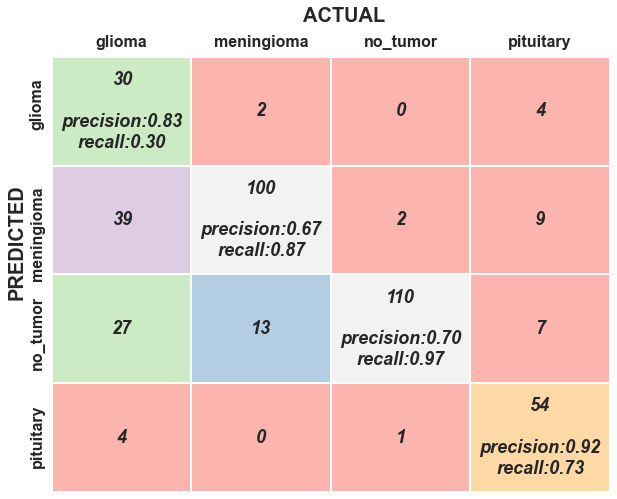

In [49]:
import seaborn as sns

mask = np.eye(*cf_matrix.shape,dtype=bool)

prLabels=[]
for k in classLabels:
    t = clfRep[k][:2]
    prLabels.append(f'precision:{t[0]:.2f}\nrecall:{t[1]:.2f}')

fig,ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(cf_matrix.T,annot=True,fmt='d',ax=ax,
                 cmap='Pastel1',cbar=False,
                 annot_kws={'weight': 'bold','style':'italic','size':'18'},
                 linewidths=1)
# add more text to the cells:
for n in np.arange(4):
    txt = hm.texts[n*5]
    txt.set_text(txt.get_text() + '\n\n'+prLabels[n])



ax.set_yticklabels(list(classLabels),rotation=90,fontweight='bold',fontsize=16)
# so the rotated y-labels are sort-of centered 
zz = ax.get_yticks()
ax.set_yticks(zz-0.25)
ax.set_xticklabels(classLabels,fontweight='bold',fontsize=16)
ax.xaxis.set_ticks_position('top')
ax.annotate('PREDICTED',xy=(0,0),xytext=(-0.08,0.45),xycoords='axes fraction',rotation = 90,fontweight='bold',fontsize=20);
ax.annotate('ACTUAL',xy=(0,0),xytext=(0.45,1.08),xycoords='axes fraction',rotation = 0,fontweight='bold',fontsize=20);
plt.savefig(getFigurePath('ConfusionMatrixHeatmap.png'),bbox_inches='tight')
plt.show()
print()


## **Future directions**
- Analyze mis-classified images to gain insights into the nature of the problem
- Get a better understanding of the variations in images due to source by checking image associated meta-data including slice orientation (axial, sagittal,coronal).
- The model will learn to differentite local features better if we coud get ground-truth bounding boxes for the location of tumor.
- Model stacking to explore building multiple models for different categories could also help in improving recal and high precision for all classes
- Finally the availability of good segmentation data would go a long way in training and building a more robust model.

fileIds testLabel predictedLabel  ImgIndex  misClassified
87  image(11).jpg    glioma     meningioma        87              1
64   image(4).jpg    glioma     meningioma        64              1
19  image(13).jpg    glioma     meningioma        19              1
36  image(34).jpg    glioma     meningioma        36              1
39  image(35).jpg    glioma       no_tumor        39              1
25  image(14).jpg    glioma       no_tumor        25              1
51  image(15).jpg    glioma       no_tumor        51              1
43   image(6).jpg    glioma       no_tumor        43              1
83  image(92).jpg    glioma      pituitary        83              1
63   image(5).jpg    glioma      pituitary        63              1
8   image(53).jpg    glioma      pituitary         8              1
33  image(59).jpg    glioma      pituitary        33              1

Mis-Classified Glioma tumors


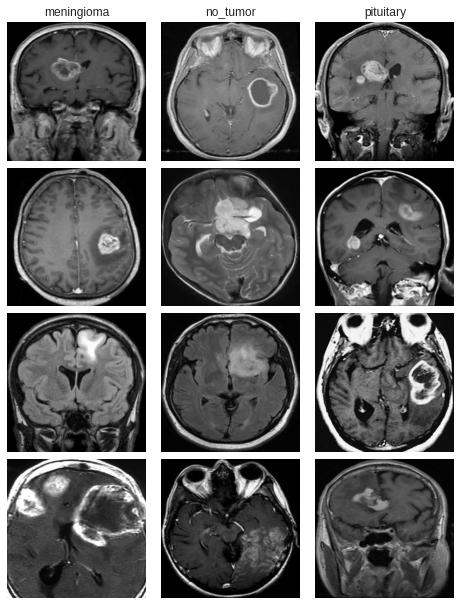





Glioma tumore in TRAINING data set are not as apparent as in test set


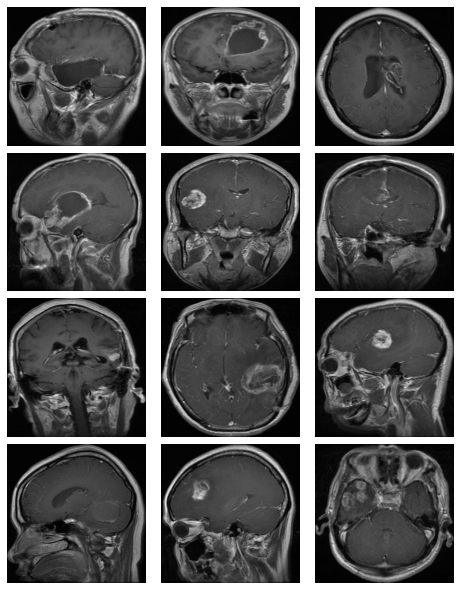

In [156]:
# Analysis of mis classified gliomas
predLabIdx = np.argmax(test_pred,axis=1)
predLabs= [classLabels[x] for x in np.argmax(test_pred,axis=1)]
classifyPredsDf = pd.DataFrame.from_dict({'fileIds':testImgSummDf['fileId'],'testLabel':testLabels,'predictedLabel':predLabs}) 
classifyPredsDf['ImgIndex'] = np.arange(len(testLabels))
classifyPredsDf['misClassified'] = [0 if classifyPredsDf['testLabel'][x]==classifyPredsDf['predictedLabel'][x] else 1 for x in np.arange(len(predLabs))]
#classifyPredsDf.sort_values(by=['misClassified','trainLabel','predictedLabel'],ascending=[False,True,True],inplace=True)
glDfIdx = np.where(classifyPredsDf['testLabel'].str.contains('glioma') & classifyPredsDf['misClassified']==1)
#trIdx = trainImgSummDf.groupby('tumorCategory').sample(n=1).index
temp = classifyPredsDf.iloc[glDfIdx]
misGlioma = classifyPredsDf.iloc[glDfIdx].groupby('predictedLabel').sample(n=4)
display(misGlioma)
print('Mis-Classified Glioma tumors')
btc.plotImageArr(4,3,(8,10),testImgs[misGlioma['ImgIndex']],rowLabels=[],colLabels=['meningioma','no_tumor','pituitary'],figFile=getFigurePath('MisClassifiedGlioma.png'))
print('\n\n\n')
print('Glioma tumore in TRAINING data set are not as apparent as in test set')
btc.plotImageArr(4,3,(8,10),trainImgs[np.arange(12)],figFile=getFigurePath('TrainingGlioma.png'))

In [ ]:
classifyPredsDf['trainLabel'][0]==classifyPredsDf['trainLabel'][x]

In [ ]:
# Not sure why KFold did not work...
# import keras
# import sklearn
# from timeit import default_timer as timer
# importlib.reload(btc)

# earlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                       min_delta= 0.0005,patience=8,restore_best_weights=True)

# def getRecommendedModel(strategy,imageShape,recoNo=1):
#     shape = imageShape
#     kernelL2 = 0.00020
#     if recoNo == 3:
#       ############# recomendation #3
#       # BaseModel-BatchNorm	ZScore	0.35	0.88	1.00	0.68	0.74
#       modelName = 'Recommend_3-BaseModel-BatchNorm-'+'ZScore'
#       model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True)
#     elif recoNo == 2:
#       ############ recomendation #2
#       # BaseModel-BatchNorm-L2Regularize	Raw	0.37	0.87	0.97	0.80	0.76
#       modelName = 'Recommend_2-BaseModel-BatchNorm-L2Regularize-'+'Raw'
#       model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2)
#     elif recoNo == 1:
#       ############ recomendation #1
#       # BaseModel-BatchNorm-L2Regularize	Laplacian 0.37	0.87	0.98	0.78	0.76
#       modelName = 'Recommend_1-BaseModel-BatchNorm-L2Regularize-'+'Laplacian'
#       model = btc.MyModel.getBaseModel(shape,strategy,numClasses=4,bNorm=True,l2Lambda=kernelL2)
      
#     return modelName,model

# run_models = True
# st = timer()
# if run_models: ## Just so we do not overwrite

#     # Read image dataset
#     imageShape = (256,256,1)
#     trainImgs,trainLabels,trainImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='training')
#     testImgs,testLabels,testImgSummDf = loadImagesDataset(imageShape=imageShape, trainOrTest='testing')
#     modelNo = 0
#     kFolds = 5 # then test_split = 0.2
#     # collect data for later analysis
#     # modelHistories = {} # we do not need history as we are not plotting progress
#     evalMetricsDf = None
#     classifReportDf = None
#     for recoNo in [3,2,1]:
#         # create recommended name for the model
#         name,_ = getRecommendedModel(strategy,imageShape,recoNo)
#         modelTimer=timer()
#         modelNo = modelNo + 1
#         # Pre-process images: the last part of the model name has the preProcName
#         preProcName = name.split('-')[-1]
#         fx = btc.getPreProcFx(preProcName)
#         print(f'\nRunning image pre-processing for function: {preProcName}')
#         train_x = np.expand_dims(np.array([fx(xx) for xx in trainImgs]),axis=3)
#         test_x = np.expand_dims(np.array([fx(xx) for xx in testImgs]),axis=3)
#         # OneHotEncode class names
#         tumorCategoryOHE = sklearn.preprocessing.OneHotEncoder()
#         train_y = tumorCategoryOHE.fit_transform(trainLabels[tr_ix].values.reshape(-1, 1)).toarray()
#         test_y = tumorCategoryOHE.transform(testLabels.values.reshape(-1,1)).toarray()
#         classLabels = [x.replace('x0_','') for x in tumorCategoryOHE.get_feature_names()]
#         # KFold cross validation for each model
#         print('Doing StratifiedKFold')
#         kFoldSplits = sklearn.model_selection.StratifiedKFold(n_splits=kFolds,shuffle=True,random_state=42)
#         foldNo = 0
#         foldTimer = timer()
#         for tr_ix, vl_ix in kFoldSplits.split(train_x,trainLabels):
#             # For every fold get a new model, else we will be training model that is already trained
#             _,model = getRecommendedModel(strategy,imageShape,recoNo)
#             # using already fit One Hot encoder now transform for split
#             train_y = tumorCategoryOHE.transform(trainLabels[tr_ix].values.reshape(-1,1)).toarray()
#             val_y = tumorCategoryOHE.transform(trainLabels[vl_ix].values.reshape(-1,1)).toarray()
#             trSize = len(train_y)
#             vlSize = len(val_y)
#             print(f'train nos : {trSize} val nos: {vlSize}, test_size: {(vlSize/(trSize+vlSize)):.2f} ')
#             foldTimer = timer()
#             foldNo = foldNo + 1
#             model.fit(train_x[tr_ix],train_y,batch_size=16,epochs=50,
#                       verbose=0,callbacks = earlyStopping)
#             print(f'fold {foldNo} Time taken to fit  : {timer()-foldTimer:.3f}s')
#             model.save(getModelPath(name+'_'+str(foldNo)+'.h5'))
#             # Evaluate model
#             metricValues = [[x] for x in m.evaluate(train_x[vl_ix],val_y)]
#             temp = pd.DataFrame.from_dict(dict(zip(model.metrics_names,metricValues)))
#             temp['modelName'] = name
#             temp['foldNo'] = foldNo
#             display(temp)
#             if evalMetricsDf is None:
#                 evalMetricsDf = temp.copy()
#             else:
#                 evalMetricsDf = evalMetricsDf.append(temp)
#             # get classification report for the fold
#             temp = btc.getClassificationReport(model,test_x,test_y,classLabels,asDataframe=True)
#             temp['modelName'] = name
#             temp['foldNo'] = foldNo
#             display(temp)
#             if classifRepDf is None:
#                 classifRepDf = temp.copy()
#             else:
#                 classifRepDf = classifRepDf.append(temp)
#             del model
#             del temp
#         # End folds for model
#         print(f'Time taken to fit all folds for model {name} : {timer()-modelTimer:.3f}s')
#     # End models
#     print(f'Time taken to fit all folds for all model  : {timer()-st:.3f}s')


In [ ]:
kFoldSplits = sklearn.model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for tx,vx in kFoldSplits.split(trainImgs,trainLabels):
    display(btc.getLabelDistributionDf({'tr':trainLabels[tx],'vx':trainLabels[vx]}))


tr  trFraction     vx  vxFraction
glioma       663.0    0.287760  166.0    0.287695
meningioma   664.0    0.288194  166.0    0.287695
no_tumor     316.0    0.137153   79.0    0.136915
pituitary    661.0    0.286892  166.0    0.287695
Total       2304.0    1.000000  577.0    1.000000

tr  trFraction     vx  vxFraction
glioma       663.0    0.287636  166.0    0.288194
meningioma   664.0    0.288069  166.0    0.288194
no_tumor     316.0    0.137093   79.0    0.137153
pituitary    662.0    0.287202  165.0    0.286458
Total       2305.0    1.000000  576.0    1.000000

tr  trFraction     vx  vxFraction
glioma       663.0    0.287636  166.0    0.288194
meningioma   664.0    0.288069  166.0    0.288194
no_tumor     316.0    0.137093   79.0    0.137153
pituitary    662.0    0.287202  165.0    0.286458
Total       2305.0    1.000000  576.0    1.000000

tr  trFraction     vx  vxFraction
glioma       663.0    0.287636  166.0    0.288194
meningioma   664.0    0.288069  166.0    0.288194
no_tumor     316.0    0.137093   79.0    0.137153
pituitary    662.0    0.287202  165.0    0.286458
Total       2305.0    1.000000  576.0    1.000000

tr  trFraction     vx  vxFraction
glioma       664.0    0.288069  165.0    0.286458
meningioma   664.0    0.288069  166.0    0.288194
no_tumor     316.0    0.137093   79.0    0.137153
pituitary    661.0    0.286768  166.0    0.288194
Total       2305.0    1.000000  576.0    1.000000

# **Cleanup**
- Finally if in Colab environment cleanup as a good citizen!

In [ ]:
#cleanup()